## <center>Дипломный проект. 

### <center>«Модель прогнозирования стоимости жилья для агентства недвижимости»

In [1]:
import pandas as pd
import numpy as np
import re
from zipfile import ZipFile

import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, binarize, LabelEncoder, OneHotEncoder
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn import metrics

import optuna

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

In [12]:
with ZipFile("data/data.csv.zip") as myzip:
    data_r = myzip.open("data.csv")
df = pd.read_csv(data_r)

### Признаки в данных

* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [13]:
data = df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [6]:
data.head(1)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"


In [14]:
# Поиск и удаление дубликатов в данных
print(f'Количество дубликатов в данных: {data.duplicated().sum()}')
data.drop_duplicates(inplace=True, ignore_index=True)
print(f'Количество дубликатов в данных после удаления: {data.duplicated().sum()}')

Количество дубликатов в данных: 50
Количество дубликатов в данных после удаления: 0


Проверка на выбросы по колонке target

In [15]:
# Замена текстовых символов в данных и поиск индексов с ошибками
list_garbage = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'target'] = int(str(data['target'][y]).replace('$', '').replace(',', '').replace('+', '').replace('nan', '0')\
            .replace('/mo', ''))
    except ValueError:
        list_garbage.append(y)

print(list_garbage)
# С ошибкой был один индекс который содержал данные отличные от всех. Преобразование к формату без лишлих символов
data.loc[330432, 'target'] = data['target'][330432].replace('$', '').replace(',', '').replace('/mo', '').split('-')
data.loc[330432, 'target'] = data['target'][330432][1].strip()

# Преобразование данных к формату int32
data = data.astype({'target': 'int32'})

[330432]


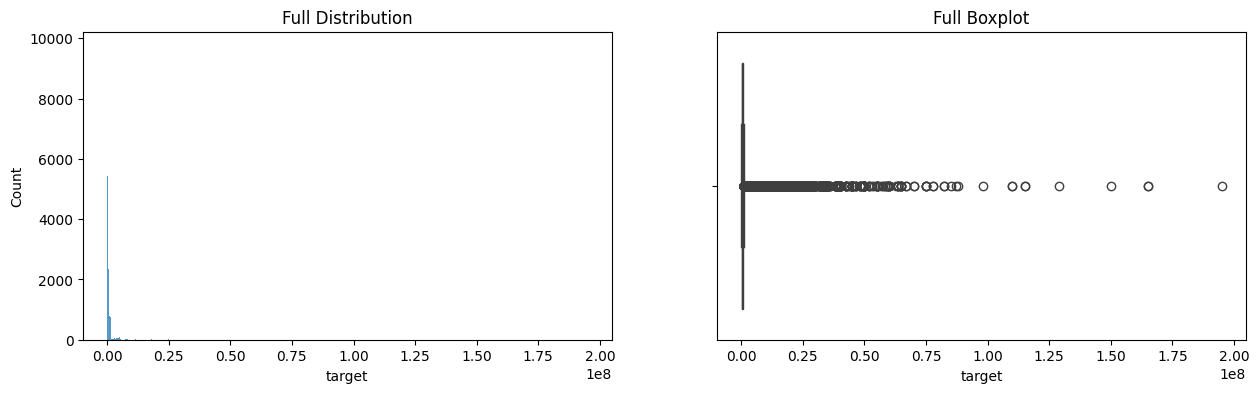

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='target', ax=axes[0]);
histplot.set_title('Full Distribution');
boxplot = sns.boxplot(data=data, x='target', ax=axes[1]);
boxplot.set_title('Full Boxplot');

Явное присутствие выбросов

Очищаю данные от выбросов по методу Тьюки с ограничением в 1,5 межквартильного размаха

In [16]:
# Функция удаления выбросов с регулировкой верхнего и нижнего предела
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

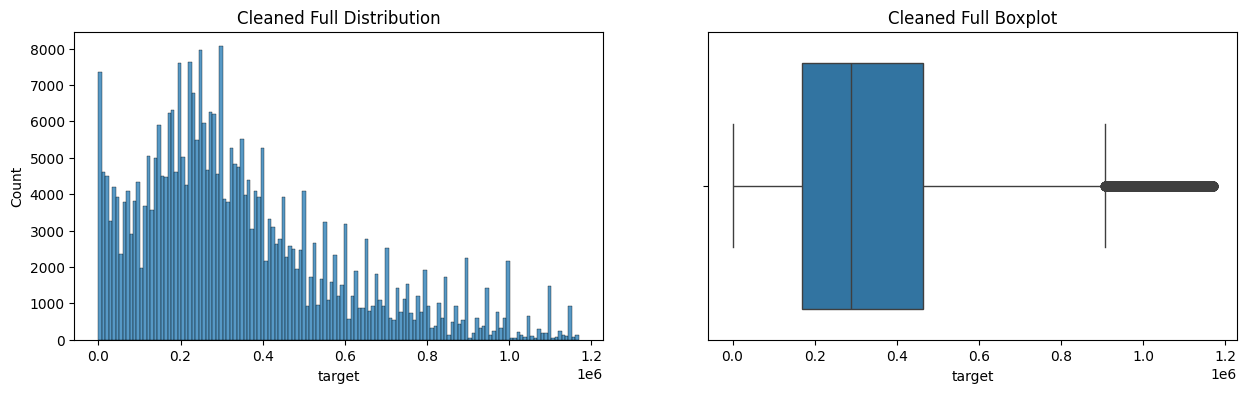

In [17]:
outliers, data = outliers_iqr_mod(data, 'target')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='target', ax=axes[0]);
histplot.set_title('Cleaned Full Distribution');
boxplot = sns.boxplot(data=data, x='target', ax=axes[1]);
boxplot.set_title('Cleaned Full Boxplot');

Очищенные данные сохранили допустимый уровень выбросов

Переиндексация после удаления выбросов

In [18]:
data.reset_index(inplace=True, drop=True)

Значения признаков 'homeFacts' и 'schools'являются строками содержащими разную информацию. 

Выделяю эту информацию в отдельные признаки

In [155]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: x.replace("{'atAGlanceFacts': [", '').replace('{', '')\
                        .replace(']}', '').replace('\"', "'"))
data['homeFacts'] = data['homeFacts'].apply(lambda x: x.split('},'))

In [156]:
list_error = []
for x in range(data.shape[0]):
    try:
        list_dict = {}
        for y in data['homeFacts'][x]:
            y = str(y.replace(" '", '').replace('None', "'").replace('}', '').replace(',,', "', ").replace('$', '')\
                    .replace("',", "'@")).split('@')
            list_dict[y[1].split(':')[1].replace("'", '')] = 0 if y[0].split(':')[1].replace("'", '') == '' \
                else y[0].split(':')[1].replace("'", '').replace(',', '.')
    except IndexError:
        list_error.append(x)


In [157]:
list_error

[35393, 38672, 235732, 242005, 264838, 265224, 327200]

In [158]:
def home_func(lanceFacts):
    list_dict = {}
    for y in lanceFacts:
        y = str(y.replace(" '", '').replace('None', "'").replace('}', '').replace(',,', "', ").replace('$', '')\
                .replace("',", "'@")).split('@')
        list_dict[y[1].split(':')[1].replace("'", '')] = 0 if y[0].split(':')[1].replace("'", '') == '' \
            else y[0].split(':')[1].replace("'", '').replace(',', '.')
            
    return list_dict

In [159]:
def home_func_1(lanceFacts):
    list_dict = {}
    for y in lanceFacts:
        y = str(y.replace(" '", '').replace('None,', "'").replace('}', '').replace(',,', "', ").replace('$', '')\
                .replace("',", "'@")).split('@')
        list_dict[y[1].split(':')[1].replace("'", '')] = 0 if y[0].split(':')[1].replace("'", '') == '' \
            else y[0].split(':')[1].replace("'", '').replace(',', '.')
            
    return list_dict

In [160]:
def home_func_2(lanceFacts):
    list_dict = {}
    lanceFacts = str(list(lanceFacts)).replace('None,', '",').replace(" \'", '').replace("\'", '').replace('", Detached', 'Detached')\
        .replace(' ",', ',').split('",')

    for y in lanceFacts:
        y = y.replace('[', '').replace('"', '').replace('}]]', '').split(',')
        list_dict[y[1].split(':')[1]] = 0 if y[0].split(':')[1] == ' ' else y[0].split(':')[1]
            
    return list_dict

In [161]:
# Создание списков параметров которые в процессе обработки имели различия в содержании и не могли быть обработанны одним кодом
list_all_index = (data.index.to_list())
list_nan_index = [35393, 38672, 235732, 242005, 264838, 265224]
list_2nan_index = [327200] # Данную строку видимо вообще лучше удалить, так как она не имеет стоимости объекта
list_with_nan = list(set(list_all_index) - set(list_nan_index) - set(list_2nan_index))

In [162]:
# # Обработка параметра homeFacts. Из строкового значения извлекаются нужные данные и составляется словарь
data.loc[list_with_nan, 'homeFacts'] = \
    data.loc[list_with_nan, 'homeFacts'].apply(lambda x: home_func(x))

In [163]:
data.loc[list_nan_index, 'homeFacts'] = \
    data.loc[list_nan_index, 'homeFacts'].apply(lambda x: home_func_1(x))

In [164]:
data['homeFacts'][327200] = home_func_2(data['homeFacts'][list_2nan_index])

### Используя значение homeFacts извлекаю данные и создаю новые колонки со значениями

In [165]:
list_er = []
try:
    for ind_ex in range(data.shape[0]):

        for column_home in data['homeFacts'][0].keys():
            data.loc[ind_ex, column_home] = str(data['homeFacts'][ind_ex][column_home]).replace('/sqft', '').replace('sqft', '')
except TypeError:
    list_er.append(ind_ex)

In [166]:
list_er

[]

In [167]:
data.drop('homeFacts', axis=1, inplace=True)

### Преобразование параметра Heating

In [168]:
data['Heating'] = data['Heating'].apply(lambda x: str(x).lower())
data['Heating'] = data['Heating'].apply(lambda x: 'no data' if x == '0' or x == '' or x == ' ' else x)

data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('.', '').strip())

data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('/', ' '))
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('gas heat', 'gas'))
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace(' - heat', ''))
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('natural', '').strip())
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('  ', ' ').strip())
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('central heating', 'central'))
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('central furnace', 'central'))
data['Heating'] = data['Heating'].apply(lambda x: str(x).replace('forced air heating', 'forced air')\
        .replace('forced air other', 'forced air').replace('hot air', 'forced air').replace('forcedair', 'forced air'))

data['Heating'] = data['Heating'].apply(lambda x: 'central air' if 'central air' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'central electric' if 'central' in x and 'elect' in x or 'heat-elec' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'central gas' if 'central gas' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'forced air' if 'forced' in x and 'air' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'forced air gas' if 'forced air' in x and 'gas' or 'propane' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'refrigeration' if 'refrigeration' in x or 'condition' in x\
    or 'conditioners' in x or 'electric cooling' in x or 'trane hvac' in x or 'cooling' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'central cooling' if 'central' in x and 'cooling' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'other' if 'other' in x or 'has heating' in x or 'multizone heat' in x\
    or 'yes' in x  or 'radiant' in x or 'basement' in x or 'zone' in x or 'floor' in x or 'bathroom' in x 
    or '1' in x or '2' in x in x or '3' in x in x or '5' in x or '9' in x  or 'heating' in x or 'gravity' in x 
    or 'dual' in x or 'apply' in x or 'garage' in x or 'lower' in x or 'room' in x or 'reverse' in x or 'thermostat' in x 
    or 'unit' in x or 'monitor' in x or 'mixed' in x  or 'high' in x or 'furnace' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'hot water' if 'hotwater' in x or 'water heaters' in x\
    or 'hot water' in x or 'steam' in x  or 'tank' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'wall' if 'wall' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'window' if 'window' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'electric gas' if 'electric' in x and 'gas' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'electric' if 'elec' in x and 'central' not in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'central gas' if 'central' in x and 'gas' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'gas' if 'gas' in x or 'propan' in x and 'electric' not in x\
                                            and 'central' not in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'baseboard' if 'baseboard' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'central fireplace' if 'central' in x and 'fireplace' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'fireplace' if 'fireplace' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'stove' if 'stove' in x or 'wood' in x or 'pellet' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'not' if 'ceiling' in x and 'fan' in x or 'contact manager' in x \
    or 'closet-on demand' in x or 'laundry room-tank' in x or 'utility room' in x or 'incentive' in x or 'closet' in x\
    or 'common' in x or 'cooler' in x or 'fans' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'central' if 'central' in x and 'boiler' in x or 'system' in x\
    or 'combination' in x or 'heat' in x or '(central)' in x or 'two' in x or 'demand' in x or 'summer' in x or 'roof' in x \
        or 'a c' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'central heat pump' if 'central' in x and 'heat pump' in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'solar' if 'solar' in x or 'star' in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'heat pump' if 'heat pump' in x or 'heatpump' in x and 'central' not in x else x)

data['Heating'] = data['Heating'].apply(lambda x: 'oil' if 'oil' in x and 'central' not in x else x)
data['Heating'] = data['Heating'].apply(lambda x: 'radiator' if 'radiator' in x else x)

data['Heating'].value_counts()

Heating
gas                 141509
no data             103550
other                32981
central              16246
electric             13388
central electric     13285
central air           8811
baseboard             3569
wall                  3284
refrigeration          986
hot water              476
oil                    211
stove                  123
radiator               119
not                     72
fireplace               41
solar                   21
window                  13
ceiling central         12
central oil              3
Name: count, dtype: int64

### Преобразование параметра Cooling

In [169]:
data['Cooling'] = data['Cooling'].apply(lambda x: str(x).lower().strip())
data['Cooling'] = data['Cooling'].apply(lambda x: str(x).replace(',', '').replace('.', '').replace('/', '').replace('-', ''))
data['Cooling'] = data['Cooling'].apply(lambda x: 'central' if 'central' in x else x)
data['Cooling'] = data['Cooling'].apply(lambda x: 'not' if '0' in x or 'no data' in x or 'gas' in x  or 'baseb' in x or 'ceiling' in x\
    or 'floor' in x or 'stove' in x or 'included' in x or 'oil' in x or 'radi' in x or 'heat' in x or 'hot' in x or 'remar' in x\
    or 'no ac' in x or 'manage' in x or 'propan' in x or 'butane' in x or 'wood' in x or 'keros' in x or 'dehumidifier' in x\
    or 'evapor' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'has cooling' if 'unit' in x or 'cool' in x or 'refrig' in x or 'wall' in x\
    or 'wind' in x or 'forc' in x or 'condi' in x or 'star' in x or 'split' in x or 'dual' in x or 'zone' in x or 'yes' in x\
    or '1' in x or '2' in x or '3' in x or 'inc' in x or 'apply' in x or 'separ' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'other' if 'other' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'fan' if 'fan' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'central' if 'cenrtal' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'has cooling' if 'ac' in x or 'room' in x or 'high' in x or 'monitor' in x\
    or 'progr' in x or 'contr' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'solar' if 'solar' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'electric' if 'electr' in x else x)

data['Cooling'] = data['Cooling'].apply(lambda x: 'no data' if x == '' else x)

data['Cooling'].value_counts()

Cooling
central        183769
not            131389
has cooling     17664
no data          3241
other            1702
electric          896
fan                25
solar              14
Name: count, dtype: int64

### Преобразование параметра Parking

In [170]:
data['Parking'] = data['Parking'].apply(lambda x: str(x).replace('.', '').replace(',', '').replace('/', '').replace('-', '').lower())

data['Parking'] = data['Parking'].apply(lambda x: 'no parking' if 'no parking' in x or 'no' in x or 'swim' in x or '0' in x \
    or 'other' in x or 'dwearth' in x or 'dtach' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '1' if '1' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '2' if '2' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '3' if '3' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '4' if '4' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '5' if '5' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '6' if '6' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '7' if '7' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '8' if '8' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: '9' if '9' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: 'garage' if 'garage' in x or 'gar' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: 'street' if 'street' in x or 'driv' in x or 'drv' in x or 'grav' in x or 'aggre' in x\
     or 'paved' in x or 'pvt' in x or 'off site' in x or 'asphalt' in x or 'aspht' in x or 'concr' in x or 'pavers' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: 'carport' if 'carport' in x or 'alley' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: 'yes' if 'parking' in x and 'desc' in x or 'type' in x or 'yn' in x else x)
data['Parking'] = data['Parking'].apply(lambda x: 'yes' if 'attached' in x or 'door' in x or 'assigned' in x or 'yn' in x\
    or 'detached' in x or 'covered' in x or 'basement' in x or 'rv' in x or 'under' in x or 'pad' in x or 'parking space' in x\
    or 'on site' in x or 'common' in x or 'bldg' in x or 'unit' in x or 'concrete' in x or 'builtin' in x or 'possible' in x \
    or 'deeded' in x or 'apply' in x or 'lot' in x or 'valet' in x or 'reqd' in x else x)

data['Parking'] = data['Parking'].apply(lambda x: 'guest' if 'guest' in x else x)

data['Parking'] = data['Parking'].apply(lambda x: 'rent' if 'rent' in x or 'sale' in x or 'cash' in x else x)

data['Parking'] = data['Parking'].apply(lambda x: 'yes' if 'parking' in x and 'no' not in x else x)

data['Parking'] = data['Parking'].apply(lambda x: 'controlled entrance' if 'cable tv' in x else x)

data['Parking'] = data['Parking'].apply(lambda x: 'no data' if x == ' ' else x)

data['Parking'].value_counts()

Parking
no parking             170327
garage                  85657
2                       30845
1                       17006
street                  10875
carport                  7723
3                        4552
yes                      3906
no data                  3240
4                        2829
6                         675
5                         518
8                         241
7                         118
open                       67
9                          51
guest                      31
oversized                  13
rent                        8
boat                        6
controlled entrance         3
tandem                      3
cirdw                       2
side vehicle entry          2
near public transit         2
Name: count, dtype: int64

### Преобразование параметра lotsize

In [171]:
data['lotsize'] = data['lotsize'].apply(lambda x: str(x).lower())
data['lotsize'] = data['lotsize'].apply(lambda x: str(x).replace('sq. ft.', '').replace('lot', '').replace('.', '').strip())
# В значениях есть пропуски. Заменяю на no data
data['lotsize'] = data['lotsize'].apply(lambda x: 'no data' if x == '' else x)

# Поиск значений в данных отличных от типа int
list_acr = []
for x in range(data.shape[0]):
    str_acr = data['lotsize'][x].split(' ')
    if len(str_acr) > 1:
        list_acr.append(str_acr[1])
list_uniq_acr = list(set(list_acr))
print(f'Строковые значения в данных: \033[3m\033[33m{list_uniq_acr}\033[0m')

# Создание списка индексов значений int
list_ind_index = []
for x in range(data.shape[0]):
    str_acr = data['lotsize'][x].split(' ')
    if len(str_acr) == 1:
        list_ind_index.append(x)

# В данных оказался ещё мусор, поиск мусорных значений
list_type = []
for x in list_ind_index:
    try:
        # Преобразование квадратных футов в акры.
        if data['lotsize'][x] != '0':
            data.loc[x, 'lotsize'] = round(int(data['lotsize'][x]) / 42895, 2)
    except ValueError:
        list_type.append(data['lotsize'][x])
print(f'Пропуски в данных: \033[3m\033[33m{set(list_type)}\033[0m')

# Замена найденных мусорных значений на no data
data['lotsize'] = data['lotsize'].apply(lambda x: str(x).replace('--', 'no data').replace('—', 'no data'))
# Удаление определения acres. Так как всё числовые значения преобразованы в acres
data['lotsize'] = data['lotsize'].apply(lambda x: str(x).replace('acres', '').replace('acre', '').strip())

data['lotsize'].value_counts()

Строковые значения в данных: ['acre', 'data', 'acres']
Пропуски в данных: {'—', '--'}


lotsize
no data    54978
0          29142
0.17       11849
0.23       10603
0.15       10112
           ...  
16.05          1
6.8            1
5578           1
10.72          1
10100          1
Name: count, Length: 3878, dtype: int64

### Преобразование и поиск ошибок в параметре Year built

In [172]:
# В данных есть значение с пробелом, преобразую в no data
data['Year built'] = data['Year built'].apply(lambda x: str(x).lower())
data['Year built'] = data['Year built'].apply(lambda x: 'no data' if x == ' ' or x == '' or x == '0' else x)

In [173]:
# Поиск ошибок в данных
list_err_year = []
for x in range(data.shape[0]):
    if data['Year built'][x] != 'no data':
        if len(list(data['Year built'][x])) != 4:
            list_err_year.append(data['Year built'][x])
set(list_err_year)

{'1', '559990649990'}

In [174]:
# Замена ошибок на no data
data['Year built'] = data['Year built'].apply(lambda x: 'no data' if x == '1' or x == '559990649990' else x)

In [175]:
data['Year built'].value_counts()

Year built
no data    57176
2019       28794
2006        7328
2005        6819
2007        6395
           ...  
1809           1
1807           1
1828           1
1823           1
1804           1
Name: count, Length: 220, dtype: int64

### Преобразование и поиск ошибок в параметре Remodeled year

In [176]:
# Всё в нижний регистр
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: str(x).lower())
# В данных есть значение с пробелом и 0, преобразую в no data
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: 'no data' if x == ' ' or x == '' or x == '0' else x)


In [177]:
# Поиск ошибок в данных
list_err_remo = []
for x in range(data.shape[0]):
    if data['Remodeled year'][x] != 'no data':
        if len(list(data['Remodeled year'][x])) != 4:
            list_err_remo.append(data['Remodeled year'][x])
set(list_err_remo)

set()

In [178]:
data['Remodeled year'].value_counts()

Remodeled year
no data    204608
2006         5044
2005         4267
2007         3829
2008         3193
            ...  
1800            1
1846            1
1888            1
1853            1
1862            1
Name: count, Length: 147, dtype: int64

### Обработка параметра 'schools'

In [113]:
def schools_func(list_schools):
    for x in ["\'", "[{", "}]", '{', '}', 'data: ', "data':", ' mi', '"', 'mi']:
        list_schools = list_schools.replace(x, '')
    list_schools = list_schools.replace("], ", ']%').split('%')

    dict_schools = {}
    for x in range(len(list_schools)):
        list_schools_temp = list_schools[x].split(':')
        dict_schools[list_schools_temp[0]] = list_schools_temp[1].replace(' NR', ' 0').replace(' None/', ' 0/').replace(' NA', ' 0')\
        .replace('NA', ' 0').replace(' to ', '-').replace(' [', '').replace(']', '').replace(", Jr.,", '_Jr.').split(',')
    return dict_schools

In [114]:
data['schools'] = data['schools'].apply(lambda x: schools_func(x))

In [115]:
# В процессе знакомства с данными выяснилось, что есть значения в которых количество рейтингов и дистанций меньше уровней 
# школ. В таких данных добавляю знаяение 0
list_col_rating = []
list_col_distance = []
list_col_name = []

r = 0
d = 0
n = 0

for x in range(data.shape[0]):
    if len(data['schools'][x]['Grades']) > len(data['schools'][x]['rating']):
        r += 1
        list_col_rating.append(x)
        temp_r = 0
        n_r = len(data['schools'][x]['Grades']) - len(data['schools'][x]['rating'])
        while n_r > temp_r:
            temp_r += 1
            data['schools'][x]['rating'].append('0')
    if len(data['schools'][x]['Grades']) > len(data['schools'][x]['Distance']):
        d += 1
        list_col_distance.append(x)
        temp_d = 0
        n_d = len(data['schools'][x]['Grades']) - len(data['schools'][x]['Distance'])
        while n_d > temp_d:
            temp_d += 1
            data['schools'][x]['Distance'].append('0')
        
    if len(data['schools'][x]['Grades']) > len(data['schools'][x]['name']):
        n += 1
        list_col_name.append(x)
        temp_n = 0
        n_n = len(data['schools'][x]['Grades']) - len(data['schools'][x]['name'])
        while n_n > temp_n:
            temp_n += 1
            data['schools'][x]['name'].append('0')

print(f'Количество несоответствия рейтинга с количеством уровня школ: \033[3m\033[33m{r}\033[0m\n\
    Количество несоответствия дистанции с количеством уровня школ: \033[3m\033[33m{d}\033[0m\n\
    Количество несоответствия имени с количеством уровня школ: \033[3m\033[33m{n}\033[0m')
      

Количество несоответствия рейтинга с количеством уровня школ: 815
    Количество несоответствия дистанции с количеством уровня школ: 815
    Количество несоответствия имени с количеством уровня школ: 1851


In [116]:
# Собираю уникальные значения параметра Grades
list_grades = []
for x in range(data.shape[0]):
    for y in data['schools'][x]['Grades']:
        if y != 'not':
            list_grades.append(y.strip())

list_grades = list(set(list_grades))
list_grades = list_grades[1:]
list_grades.sort()

In [14]:
list_grades

['0',
 '1',
 '1-10',
 '1-11',
 '1-12',
 '1-2',
 '1-3',
 '1-4',
 '1-5',
 '1-6',
 '1-7',
 '1-8',
 '10',
 '10-12',
 '10–10',
 '10–11',
 '10–12',
 '11-12',
 '11–11',
 '11–12',
 '12',
 '12–12',
 '1–1',
 '1–10',
 '1–11',
 '1–12',
 '1–2',
 '1–3',
 '1–4',
 '1–5',
 '1–6',
 '1–7',
 '1–8',
 '1–9',
 '2',
 '2-11',
 '2-12',
 '2-3',
 '2-4',
 '2-5',
 '2-6',
 '2-8',
 '2–11',
 '2–12',
 '2–2',
 '2–3',
 '2–4',
 '2–5',
 '2–6',
 '2–7',
 '2–8',
 '2–9',
 '3',
 '3-11',
 '3-12',
 '3-4',
 '3-5',
 '3-6',
 '3-8',
 '3–10',
 '3–11',
 '3–12',
 '3–4',
 '3–5',
 '3–6',
 '3–7',
 '3–8',
 '4-12',
 '4-5',
 '4-6',
 '4-7',
 '4-8',
 '4-9',
 '4–10',
 '4–11',
 '4–12',
 '4–4',
 '4–5',
 '4–6',
 '4–7',
 '4–8',
 '4–9',
 '5',
 '5-10',
 '5-11',
 '5-12',
 '5-6',
 '5-7',
 '5-8',
 '5-9',
 '5–10',
 '5–11',
 '5–12',
 '5–5',
 '5–6',
 '5–7',
 '5–8',
 '5–9',
 '6',
 '6-10',
 '6-11',
 '6-12',
 '6-7',
 '6-8',
 '6-9',
 '6–10',
 '6–11',
 '6–12',
 '6–6',
 '6–7',
 '6–8',
 '6–9',
 '7',
 '7-10',
 '7-11',
 '7-12',
 '7-8',
 '7-9',
 '7–10',
 '7–11',
 '7–

В данных есть дома рядом с которымb видимо нет школ, Заполню значения not

In [15]:
data['schools'][3]

{'rating': [''], 'Distance': [''], 'Grades': [''], 'name': ['']}

In [117]:
# Замена пропуска на 0
for x in range(data.shape[0]):
    for n in ['rating', 'Distance', 'Grades', 'name']:
        if data['schools'][x][n] == ['']:
            data['schools'][x][n] = '0'

In [118]:
# Значение под ключём name не меняю. Так как думаю вообще удалить его
data['schools'][3]

{'rating': '0', 'Distance': '0', 'Grades': '0', 'name': '0'}

### Создание новых признаков из признака schools

In [119]:
# Создаю df с новыми колонками, после объединяю с исходным df
data_1 = pd.DataFrame(0, index= data.index, columns=['preschool', 'elementary', 'middle', 'high'])
data = pd.concat([data, data_1], axis=1)
# Каким-то образом признак получился типа int. пришлось назначить его как object
data = data.astype({'high': 'object'})

In [120]:
# Заполнение вновь созданных признаков из содержания колонки schools
list_1 = []
dict_1 = {}
list_errors = []
for x in data.index.to_list():
    list_preschool = []
    list_elementery = []
    list_middle = []
    list_high = []

    try:
        for y in range(len(data['schools'][x]['Grades'])):
            dict_preschool = {}
            dict_elementery = {}
            dict_middle = {}
            dict_high = {}
            temp_str = data['schools'][x]['Grades'][y].replace('–', '-').strip().split('-')

            if len(temp_str) > 1:
                  
                if int(temp_str[1]) < 5:
                    dict_preschool['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_preschool['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_preschool['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_preschool.append(dict_preschool)


                elif 5 <= int(temp_str[1]) <= 8 and 'elementary' in data['schools'][x]['name'][y].lower():
                    dict_elementery['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_elementery['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_elementery['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_elementery.append(dict_elementery)


                elif 8 <= int(temp_str[1]) < 12 and 'middle' in data['schools'][x]['name'][y].lower():
                    dict_middle['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_middle['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_middle['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_middle.append(dict_middle)

                elif 12 <= int(temp_str[1]) <= 18:
                    dict_high['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_high['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_high['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_high.append(dict_high)

            if len(temp_str) == 1:
                temp_str[0] = temp_str[0].replace('None', '0').replace('N/A', '0').replace('PK', '0').replace('K', '0')
                 
                if int(temp_str[0]) < 5:
                    dict_preschool['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_preschool['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_preschool['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_preschool.append(dict_preschool)

                elif 5 <= int(temp_str[0]) <= 8 and 'elementary' in data['schools'][x]['name'][y].lower():
                    dict_elementery['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_elementery['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_elementery['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_elementery.append(dict_elementery)

                elif 8 <= int(temp_str[0]) < 12 and 'middle' in data['schools'][x]['name'][y].lower():
                    dict_middle['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_middle['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_middle['name'] = data['schools'][x]['name'][y].lower().strip()
                    list_middle.append(dict_middle)

                elif 12 <= int(temp_str[0]) <= 18:
                    dict_high['Distance'] = data['schools'][x]['Distance'][y].strip()
                    dict_high['rating'] = data['schools'][x]['rating'][y].strip()
                    dict_high['name'] = data['schools'][x]['name'][y].strip()
                    list_high.append(dict_high)
    except ValueError:
        list_errors.append([x, temp_str])
    else:
        if len(list_preschool) != 0:
            data['preschool'][x] = list_preschool
        else:
            data['preschool'][x] = 0
        if len(list_elementery) != 0:
            data['elementary'][x] = list_elementery
        else:
            data['elementary'][x] = 0
        if len(list_middle) != 0:
            data['middle'][x] = list_middle
        else:
            data['middle'][x] = 0
        if len(list_high) != 0:
            data['high'][x] = list_high
        else:
            data['high'][x] = 0

In [121]:
data.drop(['schools'], axis=1, inplace=True)

В процессе окончательной обработки данных schools выяснилось, что в них усть мусор: 'NR', 'None'. Ошибки были выловлены с помощью try except и собраны в уникальный список по каждому параметру.

Дальнейшие функции уже с доработкой удаления этих ошибок. В них добавлена replace

In [142]:
col_list = []
dist_list = []
rating_list = []
name_list_err = []

def col_school(col_s):
    try:
        num_schools = len(col_s)
        return num_schools
    except ValueError:
        col_list.append(col_s)

def dist_fn(dict_dist):
    try:
        dist_int = 0
        for x in range(len(dict_dist)):
            dist_int += float(dict_dist[x]['Distance'])
        return dist_int
    except ValueError:
        dist_list.append(dict_dist[x]['Distance'])

def rating_fn(dict_rating):
    try:
        rating_int = 0
        for x in range(len(dict_rating)):
            if len(dict_rating[x]['rating'].split('/')) > 1:
                rating_int += float(dict_rating[x]['rating'].split('/')[0].replace('None', '0'))
            else:
                rating_int += float(dict_rating[x]['rating'].replace('NR', '0'))
        return rating_int
    except ValueError:
        rating_list.append(dict_rating[x]['rating'])

def name_fn(dict_name):
    try:
        name_list = []
        for x in range(len(dict_name)):
            name_list.append(dict_name[x]['name'])
        return name_list
    except ValueError:
        name_list_err.append(dict_name[x]['name'])

In [148]:
for x in ['preschool', 'elementary', 'middle', 'high']:
    data[x + '_col'] = data[x].apply(lambda x: col_school(x) if x != 0 else x)
    data[x + '_distance'] = data[x].apply(lambda x: dist_fn(x) if x != 0 else x)
    data[x + '_rating'] = data[x].apply(lambda x: rating_fn(x) if x != 0 else x)
    data[x + '_name'] = data[x].apply(lambda x: name_fn(x) if x != 0 else x)

print(f'col_list: {col_list}, dist_list: {dist_list}, rating_list: {rating_list}, name_list_err: {name_list_err} ')

col_list: [], dist_list: [], rating_list: [], name_list_err: [] 


In [149]:
# Удаление исходных признаков после обработки
data.drop(['preschool', 'elementary', 'middle', 'high'], axis=1, inplace=True)

### Обработка параметра PrivatePool

In [179]:
data['PrivatePool'] = data['PrivatePool'].fillna('no')
data['PrivatePool'] = data['PrivatePool'].replace('Yes', 'yes')
data['PrivatePool'].value_counts()

PrivatePool
no     307088
yes     31612
Name: count, dtype: int64

### Обработка параметра 'private pool'

In [180]:
data['private pool'].value_counts()

private pool
Yes    3612
Name: count, dtype: int64

In [181]:
# Один из методов замены букв в значении на прописные
data['private pool'] = data['private pool'].replace('Yes', 'yes')
# Дополнение признака PrivatePool при его равенстве no на yes если таковое есть в признаке private pool
# Объединени двух столбцов по значению yes с итоговым PrivatePool
c = 0
for x in range(data.shape[0]):
    if data['private pool'][x] == 'yes' and data['PrivatePool'][x] == 'no':
        data.loc[x, 'PrivatePool'] = data['private pool'][x]
        c += 1

print(f'Было сделано \033[3m\033[33m{c}\033[0m дополнений')
print(f'Итоговое количество положительных значений в данных PrivatePool \033[3m\033[33m{data.PrivatePool.value_counts()[1]}\033[0m')

Было сделано 3612 дополнений
Итоговое количество положительных значений в данных PrivatePool 35224


Признак private pool удаляется

In [182]:
data.drop('private pool', axis=1, inplace=True)

### Обработка параметра 'status'

In [183]:
data['status'] = data['status'].replace('For sale', 'for sale').replace('For Sale', 'for sale')

data['status'] = data['status'].replace('Pre-foreclosure / auction', 'Auction').replace('Pre-foreclosure', 'Auction')\
    .replace(' / auction', 'Auction').replace('auction', 'Auction').replace('A Active', 'Auction').replace('Auction - Active', 'Auction')\
    .replace('Foreclosed' , 'Auction').replace('Foreclosure' , 'Auction').replace('foreclosure' , 'Auction')\
    .replace('Active - Auction' , 'Auction')

data['status'] = data['status'].replace('Under Contract Show', 'Contract').replace('Under Contract   Showing', 'Contract')\
.replace('Active Under Contract', 'Contract').replace('Option Contract', 'Contract')\
.replace('Contract P', 'Contract').replace('Contingency Contract', 'Contract').replace('U Under Contract', 'Contract')\
.replace('Contract Contingent On Buyer Sale', 'Contract').replace('Under Contract - Show', 'Contract')\
.replace('Under Contract Backups', 'Contract').replace('Active Option Contract', 'Contract')

data['status'] = data['status'].replace('P', 'Pending').replace('pending', 'Pending').replace('Option Pending', 'Pending')\
.replace('Pending Continue To Show', 'Pending').replace('P Pending Sale', 'Pending').replace('Active Pending', 'Pending')

data['status'] = data['status'].replace('Contingent Show', 'Contingent').replace('Pending With Contingencies', 'Contingent')\
.replace('Contingent   Show', 'Contingent').replace('Active With Contingencies', 'Contingent')\
.replace('Active Contingency', 'Contingent').replace('C', 'Contingent').replace('Contingency 48 Hr (+/ )', 'Contingent')\
.replace('Ct', 'Contingent')

data['status'] = data['status'].replace('Pi', 'Pending Inspection').replace('Contingent Finance And Inspection', 'Pending Inspection')\
.replace('Pending In', 'Pending Inspection').replace('Pending W/Insp Finance', 'Pending Inspection')\
.replace('CT Insp - Inspection Contingency', 'Pending Inspection').replace('Contingent Finance and Inspection', 'Pending Inspection')\
.replace('Pending - Taking Backups', 'Pending Inspection')

data['status'] = data['status'].replace('Apartment for rent', 'for rent').replace('Condo for rent', 'for rent')

data['status'] = data['status'].replace('Active With Offer', 'Active').replace('Active Option', 'Active').replace('Active Option', 'Active')\
.replace('Back On Market', 'Active').replace('Back on Market', 'Active').replace('C Continue Show', 'Active')

data['status'] = data['status'].replace('Pending Taking Backups', 'Closed').replace('Pending Taking Backups', 'Closed')\
.replace('Offer Pending Signature', 'Closed').replace('Backup Contract', 'Closed').replace('Active/Contingent', 'Closed')\
.replace('Active Contingent', 'Closed').replace('Pending Ab', 'Closed').replace('Active Backup', 'Closed')

data['status'] = data['status'].replace('New', 'New construction')

data['status'] = data['status'].apply(lambda x: re.sub(r'Coming soon:\s\w\w\w\s\d{,2}.', r'Pending', str(x)))
data['status'] = data['status'].apply(lambda x: re.sub(r'Pending \w*\s*\w*', r'Pending', x))

def replace_pend(pend_str):
    for x in ['Pf', 'Pending To Show', 'Pending/Backup Wanted', 'Pending/Escape Clause', 'Pending, Continue to Show',\
              'Pending- Continue to Show', 'Pending(Do Not Show)', 'Pending/ Cont.', 'Ps', 'Pending- Backup Offer Requested'\
                'Pending   Financing', 'Pending- Backup Offer Requested', 'Pending   Financing', 'Due Diligence Period']:
        pend_str = pend_str.replace(x, 'Pending')
    return pend_str

data['status'] = data['status'].apply(lambda x: replace_pend(x))

def replace_active(pend_str):
    for x in ['Reactivated', 'Temporary Active', 'Uc Continue To Show', 'Re Activated', 'Reactivated', 'Lease/Purchase', 'Accepting backups']:
        pend_str = pend_str.replace(x, 'Active')
    return pend_str

data['status'] = data['status'].apply(lambda x: replace_active(x))

def replace_contract(pend_str):
    for x in ['Under contract', 'Active with Contract', 'Conditional Contract', 'Under Contract W/ Bckp',\
         'Under Contract Taking Back Up Offers', 'Under Contract', 'Under Contract - No Show', 'Contract - No Show']:
        pend_str = pend_str.replace(x, 'Contract')
    return pend_str

data['status'] = data['status'].apply(lambda x: replace_contract(x))

def replace_conting(pend_str):
    for x in ['Contingent Escape', 'Contingent Take Backup', 'Contingent Lien Holder Release', 'Contingent   Release',\
              'Contingent - Financing', 'Contingent   Foreclosure', 'Active - Contingent', 'Contingent   No Show',\
                  'Contingent - Sale of Home', 'Conting Accpt Backups', 'Listing Extended']:
        pend_str = pend_str.replace(x, 'Contingent')
    return pend_str

data['status'] = data['status'].apply(lambda x: replace_conting(x))

data['status'] = data['status'].replace('Accepted Offer', 'Closed').replace('Lease/Purchase Pending', 'Closed')\
    .replace('Sold: $285,000', 'Closed').replace('Sold: $15,000', 'Closed').replace('recently sold', 'Closed')\
        .replace('Backup', 'Closed')

data['status'] = data['status'].replace('Active Pending', 'Pending')

data['status'].value_counts()

status
for sale            178234
Active               93671
nan                  36164
Auction              12674
Pending               6802
New construction      5391
Contract              3526
Contingent             856
Price Change           509
Closed                 461
for rent               412
Name: count, dtype: int64

### Обработка параметра 'propertyType'

In [184]:
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())

In [185]:
data['propertyType'] = data['propertyType'].replace('single-family home', 'single family home')

data['propertyType'] = data['propertyType'].apply(lambda x: 'other style' if 'other' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'other style' if 'other style' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'other style' if 'miscellaneous' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'no for sale' if 'apartment' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'no for sale' if 'transitional' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'spanish' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'victorian' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'mediterranean' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'english' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'french' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'santa barbara/tuscan' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'georgian' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'florida' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'tudor' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'colonial' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'historical' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'historic' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'old' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'mid-century' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'queen anne' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'colonial' if 'territorial/santa fe' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if 'townhome' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if 'townhouse' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if 'cottage' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if 'federal' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if 'custom' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'single family home' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'detached' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'bungalow' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'singlefamilyresidence' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'villa' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'patio' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'courtyard' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'chalet' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if 'single wide' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'ranch' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'farm' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'craftsman' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'lot' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'land' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'prairie' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'texas hill country' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if 'hill country' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'mobile' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'coach/carriage' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'carriage' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'camp' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'cabin' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if 'houseboat' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'multi family home' if 'multi' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'multi family home' if 'cluster home' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'multi family home' if 'duplex' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'contemporary' if 'contemporary' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'contemporary' if 'modern' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'traditional' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'conventional' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'european' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'tuscan' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'dutch provincial' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'traditional' if 'charleston' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'one story' if '1 story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'one story' if 'one story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'one story' if 'store & dwelling' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'one story' if 'one level unit' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'one story' if 'low rise' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if '2-story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if '2 story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if '2 stories' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if 'bi-level' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if 'two story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if 'bilevel' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'two story' if '2.5 story' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if 'tri-level' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if '3 level' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if '3 story' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if '3 stories' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if '3+ stories' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if 'triplex' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'tri story' if 'trinity' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'four story' if '4-plex' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'four story' if 'split (4 level)' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'four story' if 'fourplex' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'four story' if 'american 4-square' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'four story' if 'quad level' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: '4+ floors' if '4+ floors' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'condo' if 'condominium' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'condo' if 'condo' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'cooperative' if 'coop' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'cooperative' if 'co-op' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'mid century' if 'fmid-century' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'garden home' if 'garden home' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'garden home' if 'lake house' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'split level' if 'split-level' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'penthouse' if 'penthouse' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'penthouse' if 'split level' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'penthouse' if 'studio' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'penthouse' if 'airlite' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'high rise' if 'high-rise' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'high rise' if 'high rise' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'high rise' if 'hi-rise' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'modern' if 'modernist' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'modern' if 'modern' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'mid rise' if 'mid-rise' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mid rise' if 'mid rise' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'mid rise' if 'mid-level' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'residential' if 'residential' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'elevated' if 'elevated' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'manufactured' if 'manufactured' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'manufactured' if 'industrial' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'manufactured' if 'warehouse' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'manufactured' if 'garage storage' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'manufactured' if 'loft' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'attached' if 'attached' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'arts' if 'arts' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'arts' if 'art' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'yes' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'a-frame' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'straight thru' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'attached' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'side-by-side' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'lot' if 'lot' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'cluster home' if 'split' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'cluster home' if 'dwelling w/separate living area' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'flat' if 'flat' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'low rise' if 'less than 4 floors' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'beach home' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'moorage' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'cape' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'key west/coastal' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'resort property' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'coastal' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'beach home' if 'key west' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'log home' if 'log' in x else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'log home' if 'rustic' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'gambrel' if 'end unit' in x else x)

data['propertyType'] = data['propertyType'].apply(lambda x: 'elevated' if 'stilt house' in x else x)

In [186]:
# В данных есть пропуски заменяю на unknown
for x in range(data.shape[0]):
    if data['propertyType'][x] == ' ':
        data['propertyType'][x] = 'unknown'

In [187]:
# Создание списка с неопределёнными значениями парамтра propertyType
list_u = data['propertyType'].value_counts()[33:].index.to_list()
list_u

['post and beam',
 'fairway house',
 'conversion, rehab needed',
 'dwelling with rental',
 '30x40 building',
 'back-to-back',
 'denver square']

In [188]:
# замена неопределённых значений парамтра propertyType на unknown
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if x in list_u else x)

In [189]:
print('В параметре propertyType осталось \033[3m\033[33m{}\033[0m уникальных значения'.format(data['propertyType'].nunique()))

В параметре propertyType осталось 33 уникальных значения


### Обработка параметра 'city'

Чтобы исключить разные варианты написания городов привожу всё к нижнему уровню написания

In [190]:
print(f'Количество уникальных городов до обработки \033[3m\033[33m{data.city.nunique()}\033[0m')
data['city'] = data['city'].apply(lambda x: str(x).lower())
print(f'Количество уникальных городов после обработки \033[3m\033[33m{data.city.nunique()}\033[0m')

Количество уникальных городов до обработки 1957
Количество уникальных городов после обработки 1848


### Обработка признака baths

In [191]:
#  Обработка столбца baths
def baths(bath):
    for x in  ['ba', 'Baths', 'Bathrooms:', '+', '-0', ' / 1 / 1', ' / 1', ' / 0', ' this', ' ths']:
        bath = str(bath).replace(x, '').replace(',', '.').strip()

    for y in ['nan', '~', '-', 'SemiMod', 'Sq. Ft.', '00', '—']:
        bath = str(bath).replace(y, '0')

    return int(float(bath))

data['baths'] = data['baths'].apply(lambda x: baths(x))

In [192]:
print('После обработки получил варианты количества ванных на объекте {}'.format(sorted(data['baths'].value_counts().index.to_list())))

После обработки получил варианты количества ванных на объекте [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 28, 30, 60, 102, 241, 750]


В данных явно наблюдается ситуация с выбросами

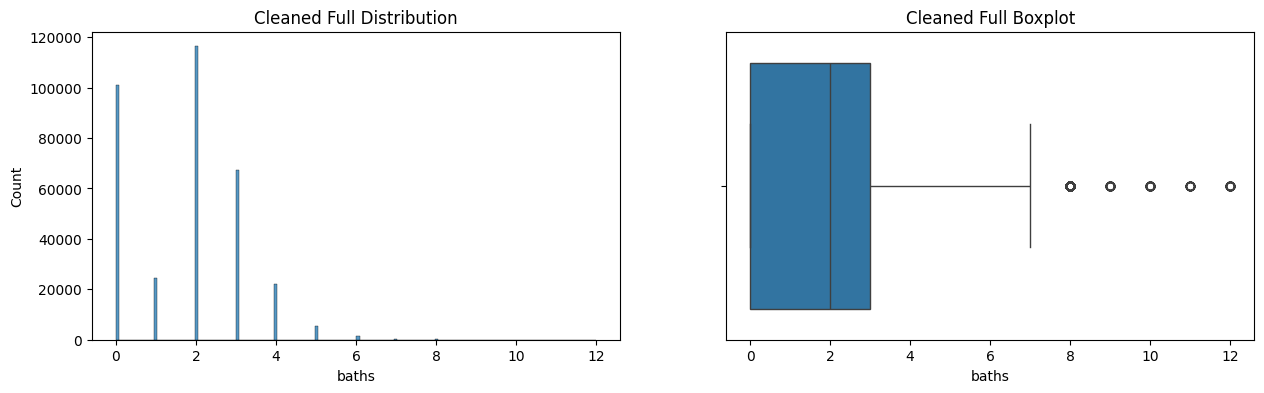

In [193]:
# Использования функции для удаления выбросов. На 3 межквартильного размаха в каждую сторону.
outliers, data = outliers_iqr_mod(data, 'baths', 3, 3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='baths', ax=axes[0]);
histplot.set_title('Cleaned Full Distribution');
boxplot = sns.boxplot(data=data, x='baths', ax=axes[1]);
boxplot.set_title('Cleaned Full Boxplot');

Данные сохранили допустимый уровень выбросов

In [195]:
data['baths'].value_counts()

baths
2     116311
0     101076
3      67259
1      24379
4      22039
5       5304
6       1359
7        415
8        158
10        37
9         36
12        33
11        22
Name: count, dtype: int64

### Обработка признака fireplace

In [196]:
# Количество уникальных значений в столбце fireplace перед обработкой
fire_uniq = data['fireplace'].nunique()
# Приведение всех значений к нижнему регистру
data['fireplace'] = data['fireplace'].apply(lambda x: str(x).lower())

#  Обработка столбца fireplace
def fireplace(fire):
    for x in  ['nan', ' no', 'no', 'hot tub', 'heatilator type system', 'extras', 'not applicable', 'study', 'firepit',\
        'extra closets, storage, utility connection, walk-in closets', 'bath features', 'elevator', 'bath']:
        fire = str(fire).replace(x, '0').strip()

    for y in ['yes', 'one', 'insert', 'in-law quarters', 'dining', 'redecorated', 'basement', 'pellet', 'masonry', '1 fireplace',\
        'outdoors', 'special features', 'log 1burning', 'fireplace', 'living room', 'wood burning', 'fireplace yn', 'fireplace features',\
             'wood', '1 yn', 'in great room', 'number', 'flue', 'coal']:
        fire = str(fire).replace(y, '1')

    return fire

data['fireplace'] = data['fireplace'].apply(lambda x: fireplace(x))

# Чтобы не вылавливать все сочетания строчных значений, решил производить замену таким способом
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'central' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'no' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'closets' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'ceiling fan' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'air filter' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'storage' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'other' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'agent' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'n/k' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if 'wet bar' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if '0' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: '1' if '1' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'family' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'room' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'brick' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'metal' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'factory' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'direct vent' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'location' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'living' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'fire' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'den' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'free' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'sm' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '1' if 'pre' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: '2' if 'two' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '2' if '2' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: '4' if '3+' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: '4' if 'four' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: '5' if '4+' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: 'gas' if 'gas' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: 'gas' if 'propane' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: 'gas' if 'utility connection' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: 'electric' if 'electric' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: 'decorative' if 'decorative' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: 'decorative' if 'ventless' in x else x)

data['fireplace'] = data['fireplace'].apply(lambda x: 'burning stove' if 'burning stove' in x else x)
data['fireplace'] = data['fireplace'].apply(lambda x: 'burning stove' if 'stove' in x else x)

print(f'Количество уникальных значений перед обработкой: \033[3m\033[33m{fire_uniq}\033[0m')
print(f'Количество уникальных значений после обработки: \033[3m\033[33m{data.fireplace.nunique()}\033[0m')
print(f'Данные в формате object\n {data.fireplace.value_counts()}')

Количество уникальных значений перед обработкой: 1393
Количество уникальных значений после обработки: 13
Данные в формате object
 fireplace
0                253809
1                 81740
2                  1712
gas                 693
3                   251
electric             79
4                    67
decorative           58
5                     8
6                     5
7                     3
8                     2
burning stove         1
Name: count, dtype: int64


### Обработка столбца beds

После обработки получил варианты количества кроватей на объекте. В данных прослеживаются выбросы
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 30, 31, 34, 40, 44, 50, 52, 63, 64, 100, 102, 106, 123, 150, 248, 448, 540, 640, 831, 840, 871]
Количество уникальных значениу по столбцу beds до обработки: 1052
после обработки, уникальных значений: 47
после удаления выбросов: 17
После удаления выбросов получил варианты количества кроватей на объекте
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


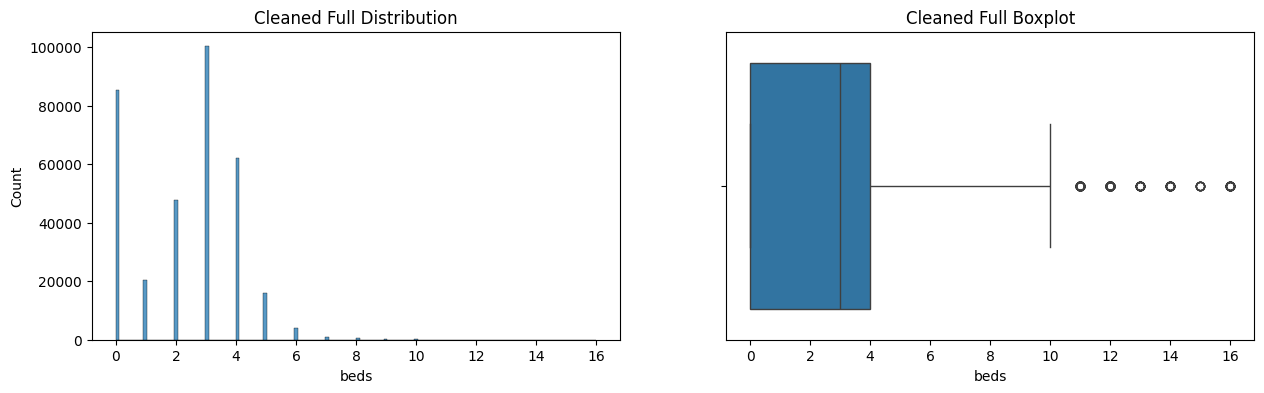

In [197]:
# Переменная количества уникальных значений до обработки
beds_uniq = data['beds'].nunique()

#  Обработка столбца beds
def beds(bed):
    for x in  [' Beds', ' bd', ' sqft', ' acres', ' acre',  'Bedrooms', '-2']:
        bed = str(bed).replace(x, '').replace(',', '.').replace('Baths', '1').replace('Bath', '1').strip()

    for y in ['nan', '-- bd', '-- sqft', '--']:
        bed = str(bed).replace(y, '0')

    return bed
    # return int(float(bed))

data['beds'] = data['beds'].apply(lambda x: beds(x))

data['beds'] = data['beds'].replace('', '0')

data['beds'] = data['beds'].apply(lambda x: '1' if 'Refrigerator' in x else x)
data['beds'] = data['beds'].apply(lambda x: '0' if 'Based' in x else x)
data['beds'] = data['beds'].apply(lambda x: '2' if 'More' in x else x)
data['beds'] = data['beds'].apply(lambda x: '1' if 'Cable' in x else x)
data['beds'] = data['beds'].apply(lambda x: '0' if 'Floor' in x else x)
data['beds'] = data['beds'].replace('1 1. 2', '1')

# Преобразование данных в цыфру
data['beds'] = data['beds'].apply(lambda x: int(float(x)))
# Переменная уникальных значений после обработки
beds_uniq_pr = data['beds'].nunique()

print('После обработки получил варианты количества кроватей на объекте. В данных прослеживаются выбросы\n\
{}'.format(sorted(data['beds'].value_counts().index.to_list())))

# Удаление выбросов из данных по умолчанию предел в 1,5 квантиля, если надо изменить его, после названия столбца надо указать новые пределы
outliers, data = outliers_iqr_mod(data, 'beds', 3, 3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='beds', ax=axes[0]);
histplot.set_title('Cleaned Full Distribution');
boxplot = sns.boxplot(data=data, x='beds', ax=axes[1]);
boxplot.set_title('Cleaned Full Boxplot');

print(f'Количество уникальных значениу по столбцу beds до обработки: \033[3m\033[33m{beds_uniq}\033[0m\n\
после обработки, уникальных значений: \033[3m\033[33m{beds_uniq_pr}\033[0m\n\
после удаления выбросов: \033[3m\033[33m{data.beds.nunique()}\033[0m')

print('После удаления выбросов получил варианты количества кроватей на объекте\n \033[3m\033[33m{}\033[0m'\
      .format(sorted(data['beds'].value_counts().index.to_list())))

Данные сохранили допустимый уровень выбросов

In [198]:
data['sqft']

0               2900
1         1,947 sqft
2                NaN
3           897 sqft
4              1,507
             ...    
338695         1,417
338696    2,000 sqft
338697    1,152 sqft
338698           NaN
338699         1,462
Name: sqft, Length: 338328, dtype: object

### Обработка признака sqft

In [199]:
sqft_uniq = data['sqft'].nunique()

def sqft_f(sqft_l):
    for x in ['sqft', 'Total interior livable area:', ',']:
        sqft_l = str(sqft_l).replace(x, '').replace('nan', '0').strip()
    
    return sqft_l

data['sqft'] = data['sqft'].apply(lambda x: sqft_f(x))

In [200]:
sqft_uniq = data['sqft'].nunique()

def sqft_f(sqft_l):
    for x in ['sqft', 'Total interior livable area:', ',']:
        sqft_l = str(sqft_l).replace(x, '').replace('nan', '0').strip()
    
    return sqft_l

data['sqft'] = data['sqft'].apply(lambda x: sqft_f(x))

data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('--', '0').replace('-', ''))

data['sqft'] = data['sqft'].apply(lambda x: int(x))
data = data.astype({'sqft': "Int32"})

print(f'Количество уникальных значений перед обработкой: \033[3m\033[33m{sqft_uniq}\033[0m')
print(f'Количество уникальных значений после обработки: \033[3m\033[33m{data.sqft.nunique()}\033[0m')

Количество уникальных значений перед обработкой: 7250
Количество уникальных значений после обработки: 7249


### Обработка признака zipcode

In [151]:
data['zipcode'].nunique()

4485

In [152]:

# Поиск данных с ошибками
list_ind = []
list_err_sqft = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'zipcode'] = int(data['zipcode'][y])

    except ValueError:
        list_err_sqft.append(data['zipcode'][y])
        list_ind.append(y)
        
list_err_sqft = set(list_err_sqft)
print(f'Значения с ошибкой в данных:\n \033[1m\033[36m{list_err_sqft}\033[0m')

Значения с ошибкой в данных:
 {'27615-3709', '77015-2522', '27610-4386', '27614-7963', '27606-2647', '27601-1141', '27612-3078', '27713-8797', '27605-1212', '27603-2352', '27610-4307', '27606-2215', '27612-5555', '27704-4346', '27614-7289', '27605-1285', '07004-1809', '27610-6088', '27609-3956', '27705-3530', '07004-1878', '27703-8355', '27609-6973', '27617-7934', '27601-2737', '27617-7891', '27703-2540', '27604-5445', '27603-2089', '27615-6925', '27607-3737', '27712-3233', '27703-9840', '27705-1944', '27615-6225', '27604-6905', '27707-4206', '27610-1749', '27616-6710', '27615-4193', '27610-1748', '07004-1300', '27615-4815', '27613-6949', '27713-8142', '27529-2107', '27604-3789', '27703-7978', '27614-8755', '27712-9088', '27606-4852', '27610-5617', '27603-8266', '27603-2692', '27713-9638', '27701-3539', '27701-4420', '27701-4415', '27529-4367', '27604-6000', '27587-9999', '27608-2709', '27614-8959', '27607-6632', '27704-5164', '27615-6304', '27610-3351', '27613-8607', '27615-1910', '27

In [153]:
data['zipcode'] = data['zipcode'].apply(lambda x: str(x).replace('--', '0'))

In [154]:
data['zipcode'].nunique()

4434

В значении zipcode при проверке были обнаружины значения с прочерками. Заменил на 0. После этого уникальных значений 4434.

In [205]:
data.reset_index(inplace=True, drop=True)

### Обработка признака stories

In [210]:
# Поиск данных с ошибками  при попытке преобразовать значение в int
# Тем самы выявлений неординарных строковых значений
list_ind_s = []
list_err_stories = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'stories'] = int(float(data['stories'][y]))

    except ValueError:
        list_err_stories.append(data['stories'][y])
        list_ind_s.append(y)
        
list_err_stories = set(list_err_stories)
print(f'Значения с ошибкой в данных:\n \033[1m\033[36m{list_err_stories}\033[0m')

Значения с ошибкой в данных:
 {'1 Story', 'Cabin/Cottage', 'Contemporary', 'Farm House', 'Cape Cod', 'Ground Level, Two', 'Modular Home', '1 Level, Non-Site Built', '1.5 Level', 'Split Foyer', 'Townhouse-2 Story, T3-Townhouse 3+ Stories', 'Multi-Story', 'Traditional', 'Condo', 'One Story', '1 Level, Site Built, Townhouse', 'Federal', 'Unimproved Commercial', 'Ranch/1 Story', '1 Level, 2 Level', '3 Level, Townhouse', 'Multi Level, Tri Level', 'One, Three Or More', 'Co-op', '1 Story/F.R.O.G.', '1.5 Story/Basement', '1.5, 2', '1 Level, Split Foyer', '1 Level, Townhouse', 'Manufactured Home, Non-Site Built', '2 Stories, Tear Down', 'Multi-Level, New Englander', '4 Story', '2 Stories, Townhouse', 'Tri Level', 'Log', 'Other, Two, Multi/Split', '1 Story, Split Level', 'Multi/Split, Two', 'Sixplex', '1, 1', 'Victorian', '2 Stories', '3 Level, Site Built, Tri-Level', 'One', 'Farm', 'Multi/Split', 'Ranch', 'Other Multi-unit', 'Two, Multi/Split', 'Stories/Levels', 'Site Built, Split Level', 'Pati

In [211]:
data['stories'] = data['stories'].apply(lambda x: 1 if '1' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'One' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'Ground' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'Modular' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'Farm' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'Patio' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'Ranch' in str(x) else x)

data['stories'] = data['stories'].apply(lambda x: 2 if '2' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if 'Two' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if 'Double' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if 'Duplex' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if 'Bi' in str(x) else x)

data['stories'] = data['stories'].apply(lambda x: 3 if '3' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 3 if 'Tri' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 3 if 'Three' in str(x) else x)

data['stories'] = data['stories'].apply(lambda x: 4 if '4' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 4 if 'Four' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 4 if 'Quad' in str(x) else x)

data['stories'] = data['stories'].apply(lambda x: 5 if '5' in str(x) else x)

data['stories'] = data['stories'].apply(lambda x: 6 if 'Six' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 6 if '6' in str(x) else x)

In [212]:
# Поиск данных с ошибками  при попытке преобразовать значение в int
# Тем самы выявлений неординарных строковых значений
list_ind_s = []
list_err_stories = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'stories'] = int(float(data['stories'][y]))

    except ValueError:
        list_err_stories.append(data['stories'][y])
        list_ind_s.append(y)
        
list_err_stories = set(list_err_stories)
print(f'Значения с ошибкой в данных:\n \033[1m\033[36m{list_err_stories}\033[0m')

Значения с ошибкой в данных:
 {'Cabin/Cottage', 'Victorian', 'Contemporary', 'Tudor', 'Multi/Split', 'Cape, Other Style', 'Cape Cod', 'Other Multi-unit', 'Garden', 'Stories/Levels', 'Split Level', 'Total Floors in Bldg', 'Bungalow', 'Site Built, Split Level', 'Live/Work', 'Bedroom - Split Plan', nan, 'Mobile', 'Split Foyer', 'Condo, Site Built', 'Multi-Story', 'Commercial', 'Traditional', 'Condo', 'Hillside', 'Detached', 'Split Level w/ Sub', 'Manufactured Singlewide', 'Federal', 'Unimproved Commercial', 'Loft', 'Multi-Level', 'Townhouse', 'Site Built', 'Co-op', 'Acreage', 'High-Rise', 'Chalet', 'Site Built, Townhouse', 'Multi Level', 'Site Built, Split Foyer', 'Lot', 'Mid-Rise', 'A Frame', 'Manufactured Home, Non-Site Built', 'Colonial', 'Craftsman', 'Condominium', 'Multi-Level, New Englander', 'Log', 'Log Home'}


In [213]:
one_story = ['Manufactured Singlewide', 'Non-Site Built', 'Site Built', 'A Frame', 'Mobile', 'Acreage', 'Bungalow', 'Chalet',\
                'Log', 'Cabin/Cottage', 'Log Home']
data['stories'] = data['stories'].apply(lambda x: '1' if x in one_story else x)

two_story = ['New Englander', 'Split Level', 'Stories/Levels', 'Split Foyer', 'Cape Cod', 'Colonial', 'Cape, Other Style',\
            'Site Built, Split Level', 'Split Level w/ Sub', 'Craftsman', 'Contemporary', 'Bedroom - Split Plan', 'Detached',\
                  'Site Built, Split Foyer']
data['stories'] = data['stories'].apply(lambda x: '2' if x in two_story else x)

three_story = ['Federal', 'Garden', 'Victorian', 'Traditional']
data['stories'] = data['stories'].apply(lambda x: '3' if x in three_story else x)

six_story = ['Mid-Rise', 'loft', 'Loft', 'Hillside', 'Townhouse', 'Tudor', 'Site Built, Townhouse']
data['stories'] = data['stories'].apply(lambda x: '6' if x in six_story else x)

twelve_story = ['Multi-Level', 'Multi Level', 'Other Multi-unit', 'Multi-Story', 'Live/Work', 'Condo', 'High-Rise',\
                  'Condominium', 'Co-op', 'Multi/Split', 'Condo, Site Built', 'Multi-Level, New Englander']
data['stories'] = data['stories'].apply(lambda x: '12' if x in twelve_story else x)

nan_story = ['Manufactured Home', 'Non-Site Built', 'Site Built', 'Unimproved Commercial', 'Commercial', 'Total Floors in Bldg',\
             'Manufactured Home, Non-Site Built', 'Lot']
data['stories'] = data['stories'].apply(lambda x: 'nan' if x in nan_story else x)


In [215]:
# Поиск данных с ошибками  при попытке преобразовать значение в int
# Тем самы выявлений неординарных строковых значений
list_ind_s = []
list_err_stories = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'stories'] = int(float(data['stories'][y]))

    except ValueError:
        list_err_stories.append(data['stories'][y])
        list_ind_s.append(y)
        
list_err_stories = set(list_err_stories)
print(f'Значения с ошибкой в данных:\n \033[1m\033[36m{list_err_stories}\033[0m')

Значения с ошибкой в данных:
 {'nan', nan}


In [216]:
data['stories'] = data['stories'].fillna('nan')

In [217]:
data['stories'].isna().sum()

0

### Обработка признака mls-id, MlsId

In [218]:
# Стандартизация значений по признаку
data['mls-id'] = data['mls-id'].apply(lambda x: str(x).lower())
data['mls-id'] = data['mls-id'].apply(lambda x: '0' if 'no' in x else x)
data['mls-id'] = data['mls-id'].apply(lambda x: '0' if 'nan' in x else x)

In [219]:
data['mls-id'].value_counts()

mls-id
0             315240
19079093           2
a10518254          2
20193103           2
201909859          2
               ...  
181965             1
48835415           1
957286             1
tr19266168         1
f10202858          1
Name: count, Length: 23064, dtype: int64

In [220]:
# Стандартизация значений по признаку
data['MlsId'] = data['MlsId'].apply(lambda x: str(x).lower())
data['MlsId'] = data['MlsId'].apply(lambda x: '0' if 'no' in x else x)
data['MlsId'] = data['MlsId'].apply(lambda x: '0' if 'nan' in x else x)
data['MlsId'] = data['MlsId'].apply(lambda x: str(x).split(','))

В ходе исследования выяснилось, что в данных MlsId есть значения разной длины, 
1. просто значение
2. на два значения
3. на три значения
4. на четыре значения

In [221]:
for x in range(data.shape[0]):
    if len(data['MlsId'][x]) == 2:
        print(data['MlsId'][x])

[' 5504', ' fl 32821']
[' 158xx', ' fl 33185']
[' 161xx', ' fl 33185']


In [222]:
list_3 = []
for x in range(data.shape[0]):
    if len(data['MlsId'][x]) == 3:
        list_3.append(data['MlsId'][x])
list_3[:3]

[[' 402', ' houston', ' tx 77098'],
 [' 23125', ' miami', ' fl 33170'],
 [' b', ' houston', ' tx 77021']]

In [223]:
list_4 = []
for x in range(data.shape[0]):
    if len(data['MlsId'][x]) == 4:
        list_4.append(data['MlsId'][x])
list_4[:3]

[['0067', ' royal cypress preserve', ' orlando', ' fl 32836'],
 ['0264', ' edison - heritage collection', ' jacksonville', ' fl 32256'],
 ['0086', ' belterra - estate collection', ' austin', ' tx 78737']]

In [224]:
data['MlsId'] = data['MlsId'].apply(lambda x: x[1].strip() if len(x) == 2 else x)
data['MlsId'] = data['MlsId'].apply(lambda x: x[2].strip() if len(x) == 3 else x)
data['MlsId'] = data['MlsId'].apply(lambda x: x[3].strip() if len(x) == 4 else x)

data['MlsId'] = data['MlsId'].apply(lambda x: x[0].strip())

In [225]:
print('После обработки признака mls-id в данных получилось \033[3m\033[33m{}\033[0m уникальных значений'.format(data['mls-id'].nunique())) 
print('После обработки признака MlsId в данных получилось \033[3m\033[33m{}\033[0m уникальных значений'.format(data['MlsId'].nunique())) 

После обработки признака mls-id в данных получилось 23064 уникальных значений
После обработки признака MlsId в данных получилось 203767 уникальных значений


Признаки mls-id, MlsId обозначают один тип данных с разным написанием и являются взаимодополняющими. 

Объединяю значения из этих признаков в одном MlsId

In [226]:
c = 0
for x in range(data.shape[0]):
    if data['mls-id'][x] != '0' and data['MlsId'][x] == '0':
        data.loc[x, 'MlsId'] = data['mls-id'][x]
        c += 1
print(f'При объединении mls-id и MlsId было сделано \033[3m\033[33m{c}\033[0m дополнений в признак MlsId вместо 0 значений')
print('Итоговое количество уникальных значений в признаке MlsId: \033[3m\033[33m{}\033[0m '.format(data['MlsId'].nunique())) 

При объединении mls-id и MlsId было сделано 23088 дополнений в признак MlsId вместо 0 значений
Итоговое количество уникальных значений в признаке MlsId: 218861 


Признак mls-id удаляется

In [ ]:
data.drop('mls_id', axis=1, inplace=True)

### Обработка признака Price/sqft

In [24]:
data['Price/sqft'].value_counts()

Price/sqft
                   52057
0                   5255
122                 1443
121                 1436
123                 1434
                   ...  
901 / Sq. Ft.          1
10714 / Sq. Ft.        1
1.495                  1
1185 / Sq. Ft.         1
1.727                  1
Name: count, Length: 2573, dtype: int64

In [54]:
# Замена строковых значений, что сразу были заметны
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('/ Sq. Ft.', '').replace('.', '').strip())
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: '0' if x == '' else x)

In [57]:
# Поиск данных с ошибками  при попытке преобразовать значение в int
# Тем самы выявлений неординарных строковых значений
list_ind_pr = []
list_err_pr = []
for y in range(data.shape[0]):
    try:
        data.loc[y, 'Price/sqft'] = int(float(data['Price/sqft'][y]))

    except ValueError:
        list_err_pr.append(data['Price/sqft'][y])
        list_ind_pr.append(y)
        
list_err_pr = set(list_err_pr)
print(f'Значения с ошибкой в данных:\n \033[1m\033[36m{list_err_pr}\033[0m')
print(f'Всего данных с ошибкой :\n \033[1m\033[36m{len(list_ind_pr)}\033[0m')

Значения с ошибкой в данных:
 {'nan', 'No Data', 'Contact manager', 'No Info'}
Всего данных с ошибкой :
 1961


In [59]:
# Замена всех строковых значений в признаке на 0
for err_pr in list_err_pr:
    data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace(err_pr, '0').strip())

In [64]:
data['Price/sqft'].value_counts()

Price/sqft
0       59273
125      1720
121      1708
128      1704
123      1698
        ...  
1284        1
1459        1
1227        1
1177        1
1727        1
Name: count, Length: 1573, dtype: int64

In [3]:
# Копирование данных
data_1 = data.copy()

In [4]:
# Замена пропусков no data  на 0
data_1['Year built'] = data_1['Year built'].replace('no data', '0')
data_1['Remodeled year'] = data_1['Remodeled year'].replace('no data', '0')
data_1['stories'] = data_1['stories'].apply(lambda x: float(str(x).replace('no data', '0')))
data_1['lotsize'] = data_1['lotsize'].replace('no data', '0')

# Разделение признаков типа object на варианты кодирования
# Кодировка выявленных признаков с числом уникальных значений до 1848 (выбрано в ручную исходя из общей таблицы)
# Удаление исходных признаков кроме тех, что кодировались с заменой в том же столбце (бинарный вариант)
list_drop = []
list_34 = []
lab = LabelEncoder()
for x in data_1.columns:
    if data_1[x].dtype == 'object':
        if data_1[x].nunique() == 2:
            data_1[x] = data_1[x].apply(lambda x: 0 if x == 'no' else 1)
        if 2 < data_1[x].nunique() <= 15:
            list_drop.append(x)
            data_1[x + '_codir'] = lab.fit_transform(data_1[x])
        if 15 < data_1[x].nunique() <= 1848:
            list_drop.append(x)
            bin_encoder = ce.BinaryEncoder(cols=[x]) # указываем столбец для кодирования
            type_bin = bin_encoder.fit_transform(data_1[x])
            data_1 = pd.concat([data_1, type_bin], axis=1)
        if data_1[x].nunique() > 1848:
            list_34.append(x)
        print(f'Уникальных значений в {x}: {data_1[x].nunique()}')

data_1.drop(list_drop, axis=1, inplace=True)
print(f'Список признаков с большим количеством уникальных значений: {list_34}')

Уникальных значений в status: 10
Уникальных значений в propertyType: 32
Уникальных значений в street: 302861
Уникальных значений в fireplace: 13
Уникальных значений в city: 1847
Уникальных значений в zipcode: 4433
Уникальных значений в state: 39
Уникальных значений в PrivatePool: 2
Уникальных значений в MlsId: 218861
Уникальных значений в preschool_name: 2113
Уникальных значений в elementary_name: 11985
Уникальных значений в middle_name: 3738
Уникальных значений в high_name: 10715
Уникальных значений в Year built: 220
Уникальных значений в Remodeled year: 147
Уникальных значений в Heating: 20
Уникальных значений в Cooling: 8
Уникальных значений в Parking: 25
Уникальных значений в lotsize: 3875
Список признаков с большим количеством уникальных значений: ['street', 'zipcode', 'MlsId', 'preschool_name', 'elementary_name', 'middle_name', 'high_name', 'lotsize']


In [5]:
# Список удалённых столбцов после кодирования
list_drop

['status',
 'propertyType',
 'fireplace',
 'city',
 'state',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking']

In [6]:
# Кодирование признаков с большим числом уникальных значений
# Через np.array что просто нереально сокращает время процесса
multi = MultiLabelBinarizer()
for x in list_34:
    print(x)
    data_1[x] = data_1[x].fillna('0')
    mls_kodir = multi.fit_transform(data_1[x])
    np_temp = np.empty((mls_kodir.shape[0], 1))
    for ind in range(data_1.shape[0]):
        np_temp[ind] = mls_kodir[ind].mean()
        
    data_1[x] = pd.DataFrame(np_temp)

street
zipcode
MlsId
preschool_name
elementary_name
middle_name
high_name
lotsize


In [7]:
X = data_1.drop('target', axis=1)
y = data_1['target']
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Обучение ML модели RandomForest 

In [8]:
%%time

rand_for = RandomForestRegressor()
model = rand_for.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrica_rforest_with_zero = metrics.r2_score(y_test, y_pred)
print(f'Метрика r2 ML модели RandomForestRegressor \033[3m\033[33m{metrica_rforest_with_zero}\033[0m')

Метрика r2 ML модели RandomForestRegressor 0.9130480262551586
CPU times: user 9min 20s, sys: 631 ms, total: 9min 21s
Wall time: 9min 21s


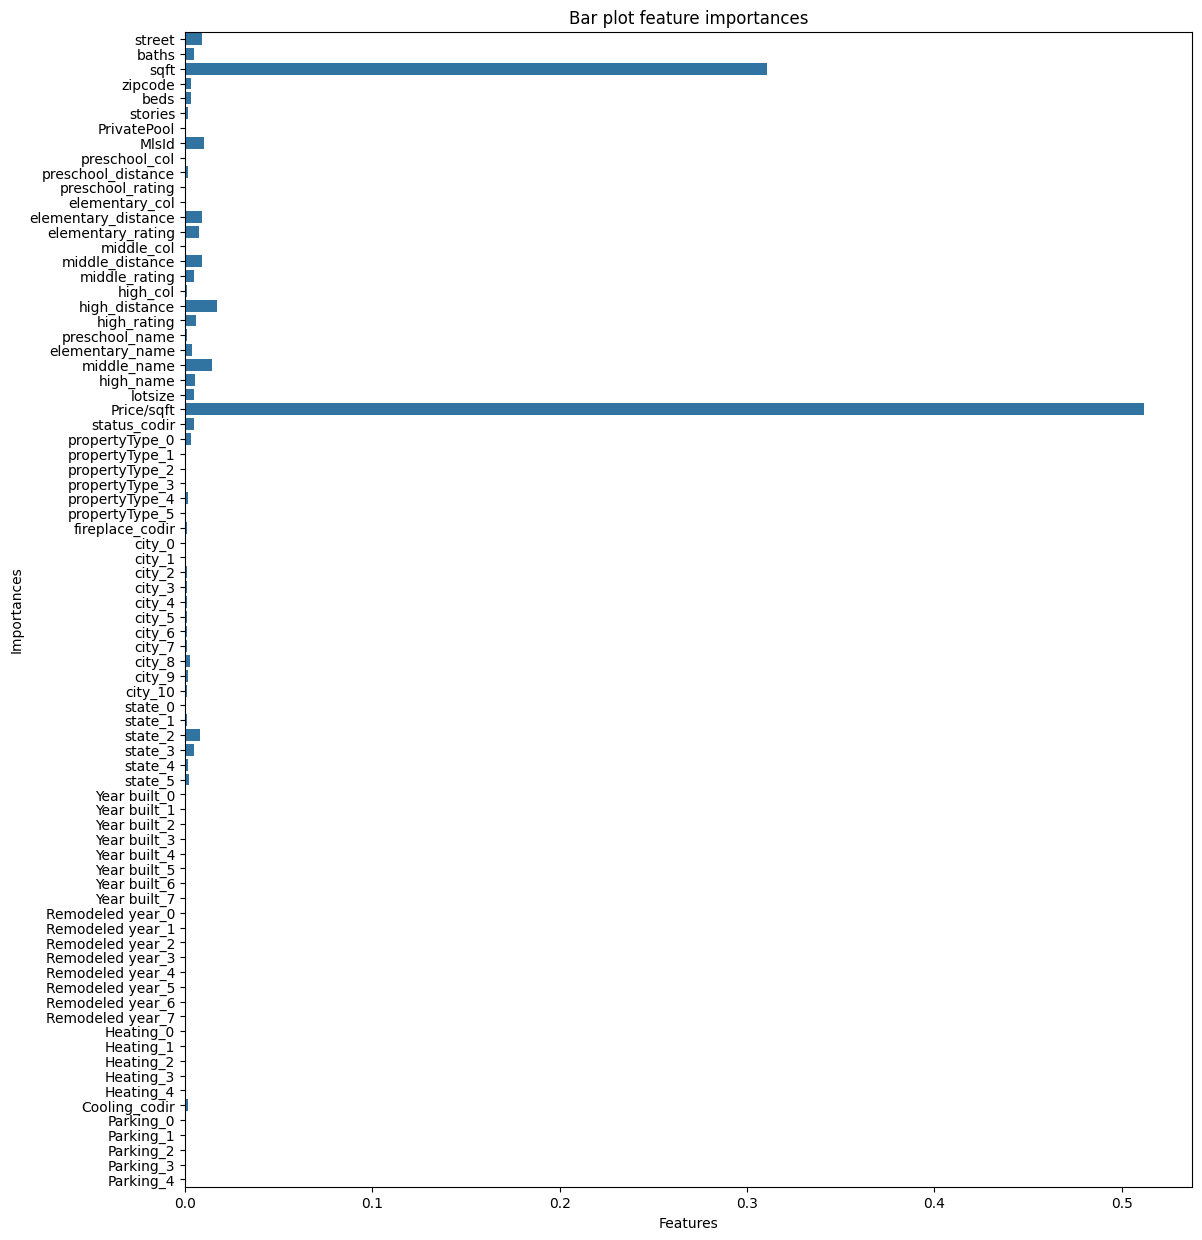

In [9]:
# Вывод графика с важностью признаков для target
fig, ax = plt.subplots(figsize=(13, 15)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = model.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature_importances, y=feature, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Исходя из полученного графика видно, что самое большое влияние на цену недвижимости имеют площадь и цена за единицу измерения

### Обучение ML модели Catboost 

так как CatBoost не нуждается в предварительной кодировке данных типа object. Кодировку не провожу.

In [10]:
data_1 = data.copy()

In [12]:
%%time
features = data_1.columns.difference(['target'])  # All columns except 'stories'
target = 'target'

# Convert categorical features to strings
categorical_features = data_1[features].select_dtypes(include=['object']).columns
for feature in categorical_features:
    data_1[feature] = data_1[feature].astype(str)

X = data_1[features]
y = data_1[target]
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Создание списка номеров признаков с типом объект
categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

# Create CatBoost pools for training and testing
train_pool = Pool(data=X_train, label=y_train, cat_features = categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features = categorical_features_indices)

# Train the CatBoost model
model = CatBoostRegressor(iterations=100, depth=11, learning_rate=0.1, loss_function='RMSE', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
model.fit(train_pool)
metrica_catboost_with_zero = metrics.r2_score(y_test, model.predict(X_test))
print('Метрика R2: \033[3m\033[33m{}\033[0m'.format({metrica_catboost_with_zero}))

0:	learn: 227195.4908380	total: 75.8ms	remaining: 7.51s
99:	learn: 69727.7339939	total: 7.62s	remaining: 0us
Метрика R2: {0.9203685141383382}
CPU times: user 19.3 s, sys: 2.5 s, total: 21.8 s
Wall time: 23.2 s


***Показатели обоих моделей ML имеют схожие уровни.***

***Высокий уровень метрики стал возможным благодаря хорошей очистке исходных данных.***

Но проведу замену пропусков. Сравню итоговые метрики

In [22]:
# Функция возвращает словарь с именами столбцов и индексами нулевых значений 
def index_null_df(df):
    df_columns = df.columns.to_list()
    dict_null = {}

    for x in df_columns:
        index_null = df[df[x].isna()].index.tolist()
        
        index_o = df[df[x] == '0'].index.tolist()
        index_o = df[df[x] == 0].index.tolist()
        
        index_null = index_null + index_o
        if len(index_null) != 0:
            dict_percentage = {}
            percentage_null = round((len(index_null) / df.shape[0] * 100), 4)
            dict_percentage['Процент_пропусков'] = percentage_null
            dict_null[x] = [dict_percentage, df[x].dtype, index_null]            
    return dict_null

dict_null_columns = index_null_df(data_1)
print(f'Статистика по нулевым значениям в столбцах:')
df_dict = pd.DataFrame(dict_null_columns)
display(df_dict.head(3))

Статистика по нулевым значениям в столбцах:


,status,propertyType,street,baths,city,sqft,beds,stories,target,preschool_col,...,elementary_col,elementary_distance,elementary_rating,middle_col,middle_distance,middle_rating,high_col,high_distance,high_rating,Price/sqft
0,{'Процент_пропусков': 10.6781},{'Процент_пропусков': 8.584},{'Процент_пропусков': 0.0006},{'Процент_пропусков': 29.8497},{'Процент_пропусков': 0.0086},{'Процент_пропусков': 13.8448},{'Процент_пропусков': 25.209},{'Процент_пропусков': 42.1623},{'Процент_пропусков': 0.7324},{'Процент_пропусков': 88.1213},...,{'Процент_пропусков': 22.039},{'Процент_пропусков': 22.0694},{'Процент_пропусков': 22.764},{'Процент_пропусков': 26.9333},{'Процент_пропусков': 26.9363},{'Процент_пропусков': 29.0026},{'Процент_пропусков': 4.4439},{'Процент_пропусков': 4.4927},{'Процент_пропусков': 5.482},{'Процент_пропусков': 17.5194}
1,object,object,object,int64,object,int64,int64,float64,int64,int64,...,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
2,"[7, 12, 26, 50, 51, 53, 88, 90, 95, 109, 115, ...","[5, 13, 20, 33, 35, 40, 54, 67, 74, 81, 91, 96...","[98407, 152433]","[2, 3, 4, 5, 9, 28, 33, 34, 35, 40, 41, 42, 52...","[19290, 23710, 54660, 73051, 109573, 110596, 1...","[2, 5, 20, 33, 34, 35, 40, 41, 42, 46, 54, 60,...","[2, 4, 5, 9, 33, 34, 35, 40, 41, 42, 52, 54, 5...","[0, 2, 5, 6, 8, 13, 16, 20, 21, 25, 27, 28, 33...","[51, 82, 105, 147, 152, 239, 240, 250, 278, 41...","[1, 2, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",...,"[3, 6, 8, 18, 23, 35, 38, 43, 66, 70, 71, 78, ...","[3, 6, 8, 18, 23, 24, 35, 38, 43, 66, 70, 71, ...","[3, 6, 8, 18, 23, 35, 38, 43, 63, 66, 70, 71, ...","[3, 4, 8, 13, 14, 16, 18, 23, 26, 29, 30, 40, ...","[3, 4, 8, 13, 14, 16, 18, 23, 26, 29, 30, 40, ...","[1, 3, 4, 8, 13, 14, 16, 18, 23, 26, 29, 30, 3...","[3, 14, 23, 66, 71, 106, 126, 133, 161, 179, 2...","[3, 14, 23, 66, 71, 106, 126, 133, 161, 179, 2...","[3, 14, 23, 66, 71, 82, 106, 126, 133, 138, 16...","[2, 20, 33, 34, 35, 40, 41, 42, 46, 50, 51, 54..."


In [15]:
dict_null_columns.keys()

dict_keys(['status', 'propertyType', 'street', 'baths', 'city', 'sqft', 'beds', 'stories', 'target', 'preschool_col', 'preschool_distance', 'preschool_rating', 'elementary_col', 'elementary_distance', 'elementary_rating', 'middle_col', 'middle_distance', 'middle_rating', 'high_col', 'high_distance', 'high_rating', 'Price/sqft'])

Из признаков с пропусками пришлось удалить три, их обработка приводила к аварийному завершению kernel. Без вывода номера ошибки. Поиск возможных вариантов решения проблемы ни к чему не привёл. 

Не смотря на это итоговая модель показала очень хорошие результаты

In [23]:
# Предполагаю, что признаки имеющие процент пропусков более 20 в результате обучения ML модели пропуски могут заполняться в итоге не
# совсем корректными данными. Поэтому ограничиваю признаки для обучаемой ML модели.
# В функции отбираются имена признаков с пропусками боолее 20% и удаляются из списка признаков на заполнение пропусков
for x in df_dict.columns:
    if df_dict.iloc[0][x]['Процент_пропусков'] > 20:
        dict_null_columns.pop(x)

dict_null_columns.keys()

dict_keys(['status', 'propertyType', 'street', 'city', 'sqft', 'target', 'high_col', 'high_distance', 'high_rating', 'Price/sqft'])

In [ ]:
# Так же из списка признаков на заполнение пропусков удаляю глобальный таргет и признаки при обработке которых аварийно завершалась работа
# ядра kernel, предполагаю из-за выхода за размер памяти на GPU
dict_null_columns.pop('target')
dict_null_columns.pop('street')
dict_null_columns.pop('city')
dict_null_columns.pop('sqft')

In [25]:
dict_null_columns.keys()

dict_keys(['status', 'propertyType', 'high_col', 'high_distance', 'high_rating', 'Price/sqft'])

### Замена пропусков в данных

Для замены пропусков использую метод с обученной ML моделью на данных с таргетом - признаком в котором необходмо заменить пропуски.

Использую CatBoost с GPU, что в несколько раз уменьшает время обучения модели в отличии от RandomForest. 

В зависимости от таргета типа int или object используются вариации классификатор или регрессор.

Чтобы код небыл молчаливым, сделал вывод в процессе его работы:
* имя признака в обработке
* результат работы CanBoost
* метрика, при обучении модели ml, по которой можно судить насколько верные данные для заполнения пропусков

Признак Price/sqft на параметрах CatBoost по умолчанию показывал плохую метрику в районе 0.11. Пришлось для этого признака выделить отдельный ML для лучшего обучения

In [27]:
%%time
for col_0 in dict_null_columns.keys():
    if col_0 == 'Price/sqft':
        features = data_1.columns.difference([col_0])  # All columns except 'stories'
        target = col_0

        # Convert categorical features to strings
        categorical_features = data_1[features].select_dtypes(include=['object']).columns
        for feature in categorical_features:
            data_1[feature] = data_1[feature].astype(str)

        mask1 = data_1[col_0].isna() != True
        mask2 = data_1[col_0] != 0.0

        data_2 = data_1[mask1 & mask2]

        data_2.reset_index(inplace=True, drop=True)

        features = data_2.columns.difference([col_0])  # All columns except 'stories'
        target = col_0

        X = data_2[features]
        y = data_2[target]
        # Разделим выборку на тренировочную и тестовую
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Создание списка номеров признаков с типом объект
        categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

        # Create CatBoost pools for training and testing
        train_pool = Pool(data=X_train, label=y_train, cat_features = categorical_features_indices)
        test_pool = Pool(data=X_test, label=y_test, cat_features = categorical_features_indices)

        print(f'Обучение ML модели на признаке \033[3m\033[33m{col_0}\033[0m')
        # Train the CatBoost model
        model = CatBoostRegressor(iterations=120, depth=15, learning_rate=0.1, loss_function='RMSE', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
        model.fit(train_pool)
        print('Метрика R2: \033[3m\033[33m{}\033[0m'.format({metrics.r2_score(y_test, model.predict(X_test))}))
    
    if data_1[col_0].dtypes != 'object':
        features = data_1.columns.difference([col_0])  # All columns except 'stories'
        target = col_0

        # Convert categorical features to strings
        categorical_features = data_1[features].select_dtypes(include=['object']).columns
        for feature in categorical_features:
            data_1[feature] = data_1[feature].astype(str)

        mask1 = data_1[col_0].isna() != True
        mask2 = data_1[col_0] != 0.0

        data_2 = data_1[mask1 & mask2]

        data_2.reset_index(inplace=True, drop=True)

        features = data_2.columns.difference([col_0])  # All columns except 'stories'
        target = col_0

        X = data_2[features]
        y = data_2[target]
        # Разделим выборку на тренировочную и тестовую
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Создание списка номеров признаков с типом объект
        categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

        # Create CatBoost pools for training and testing
        train_pool = Pool(data=X_train, label=y_train, cat_features = categorical_features_indices)
        test_pool = Pool(data=X_test, label=y_test, cat_features = categorical_features_indices)

        print(f'Обучение ML модели на признаке \033[3m\033[33m{col_0}\033[0m')
        # Train the CatBoost model
        model = CatBoostRegressor(iterations=100, depth=7, learning_rate=0.1, loss_function='RMSE', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
        model.fit(train_pool)
        print('Метрика R2: \033[3m\033[33m{}\033[0m'.format({metrics.r2_score(y_test, model.predict(X_test))}))
    
    else:

        features = data_1.columns.difference([col_0])  # Разделение данных на тренировочные и таргет
        target = col_0

        # Convert categorical features to strings
        categorical_features = data_1[features].select_dtypes(include=['object']).columns
        for feature in categorical_features:
            data_1[feature] = data_1[feature].astype(str)

        mask1 = data_1[col_0].isna() != True
        mask2 = data_1[col_0] != 0.0

        data_2 = data_1[mask1 & mask2]

        data_2.reset_index(inplace=True, drop=True)

        features = data_2.columns.difference([col_0])  # Разделение данных на тренировочные и таргет
        target = col_0

        X = data_2[features]
        y = data_2[target]
        # Разделим выборку на тренировочную и тестовую
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Создание списка номеров признаков с типом объект
        categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

        # Create CatBoost pools for training and testing
        train_pool = Pool(data=X_train, label=y_train, cat_features = categorical_features_indices)
        test_pool = Pool(data=X_test, label=y_test, cat_features = categorical_features_indices)

        print(f'Обучение ML модели на признаке \033[3m\033[33m{col_0}\033[0m')
        # Train the CatBoost model
        model = CatBoostClassifier(iterations=50, depth=2, learning_rate=0.1, loss_function='MultiClass', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
        model.fit(train_pool)
        print('Метрика f1: \033[3m\033[33m{}\033[0m'.format({metrics.f1_score(y_test, model.predict(X_test), average='micro')}))

    mask1_0 = data_1[col_0].isna() == True
    mask2_0 = data_1[col_0] == 0.0

    index_0 = np.where(mask1_0 | mask2_0)[0]
    
    X_pred = data_1[features]
    y_pred = data_1[target]

    print(f'Заполняю пропуски в признаке \033[3m\033[33m{col_0}\033[0m')
    for y in index_0:
        data_1.loc[y, col_0] = model.predict(X_pred.iloc[y])

Обучение ML модели на признаке status
0:	learn: 1.7112257	total: 80.6ms	remaining: 3.95s
49:	learn: 0.3643176	total: 3.87s	remaining: 0us
Метрика f1: {0.9052256672479532}
Заполняю пропуски в признаке status
Обучение ML модели на признаке propertyType
0:	learn: 2.1753903	total: 581ms	remaining: 28.5s
49:	learn: 0.8427878	total: 28.3s	remaining: 0us
Метрика f1: {0.7535985576212574}
Заполняю пропуски в признаке propertyType
Обучение ML модели на признаке high_col
0:	learn: 1.1105233	total: 29.4ms	remaining: 2.91s
99:	learn: 0.2450699	total: 2.95s	remaining: 0us
Метрика R2: {0.9613197982399265}
Заполняю пропуски в признаке high_col
Обучение ML модели на признаке high_distance
0:	learn: 7.8847682	total: 28.6ms	remaining: 2.83s
99:	learn: 3.0855469	total: 2.79s	remaining: 0us
Метрика R2: {0.8349560374673263}
Заполняю пропуски в признаке high_distance
Обучение ML модели на признаке high_rating
0:	learn: 3.9106439	total: 31.3ms	remaining: 3.09s
99:	learn: 1.3786669	total: 2.98s	remaining: 0us


In [28]:
data_remp_zero = data_1.copy()

In [ ]:
data_1 = data_remp_zero.copy()

### Обучение ML модели RandomForest 

In [29]:
data_1['Year built'] = data_1['Year built'].replace('no data', '0')
data_1['Remodeled year'] = data_1['Remodeled year'].replace('no data', '0')
data_1['stories'] = data_1['stories'].apply(lambda x: float(str(x).replace('no data', '0')))
data_1['lotsize'] = data_1['lotsize'].replace('no data', '0')

# Разделение признаков типа object на варианты кодирования
# Кодировка выявленных признаков с числом уникальных значений до 1848 (выбрано в ручную исходя из общей таблицы)
# Удаление исходных признаков кроме тех, что кодировались с заменой в том же столбце (бинарный вариант)
list_drop = []
list_34 = []
lab = LabelEncoder()
for x in data_1.columns:
    if data_1[x].dtype == 'object':
        if data_1[x].nunique() == 2:
            data_1[x] = data_1[x].apply(lambda x: 0 if x == 'no' else 1)
        if 2 < data_1[x].nunique() <= 15:
            list_drop.append(x)
            data_1[x + '_codir'] = lab.fit_transform(data_1[x])
        if 15 < data_1[x].nunique() <= 1848:
            list_drop.append(x)
            bin_encoder = ce.BinaryEncoder(cols=[x]) # указываем столбец для кодирования
            type_bin = bin_encoder.fit_transform(data_1[x])
            data_1 = pd.concat([data_1, type_bin], axis=1)
        if data_1[x].nunique() > 1848:
            list_34.append(x)
        print(f'Уникальных значений в {x}: {data_1[x].nunique()}')

data_1.drop(list_drop, axis=1, inplace=True)
print(f'Список признаков с большим количеством уникальных значений: {list_34}')

Уникальных значений в status: 10
Уникальных значений в propertyType: 33
Уникальных значений в street: 302862
Уникальных значений в fireplace: 13
Уникальных значений в city: 1848
Уникальных значений в zipcode: 4433
Уникальных значений в state: 39
Уникальных значений в PrivatePool: 2
Уникальных значений в MlsId: 218861
Уникальных значений в preschool_name: 2113
Уникальных значений в elementary_name: 11985
Уникальных значений в middle_name: 3738
Уникальных значений в high_name: 10715
Уникальных значений в Year built: 220
Уникальных значений в Remodeled year: 147
Уникальных значений в Heating: 20
Уникальных значений в Cooling: 8
Уникальных значений в Parking: 25
Уникальных значений в lotsize: 3875
Список признаков с большим количеством уникальных значений: ['street', 'zipcode', 'MlsId', 'preschool_name', 'elementary_name', 'middle_name', 'high_name', 'lotsize']


In [30]:
# Список удалённых столбцов после кодирования
list_drop

['status',
 'propertyType',
 'fireplace',
 'city',
 'state',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking']

In [31]:
# Кодирование признаков с большим числом уникальных значений
# Через np.array что просто нереально сокращает время процесса
multi = MultiLabelBinarizer()
for x in list_34:
    print(x)
    data_1[x] = data_1[x].fillna('0')
    mls_kodir = multi.fit_transform(data_1[x])
    np_temp = np.empty((mls_kodir.shape[0], 1))
    for ind in range(data_1.shape[0]):
        np_temp[ind] = mls_kodir[ind].mean()
        
    data_1[x] = pd.DataFrame(np_temp)

street
zipcode
MlsId
preschool_name
elementary_name
middle_name
high_name
lotsize


In [32]:
X = data_1.drop('target', axis=1)
y = data_1['target']
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
%%time

rand_for = RandomForestRegressor()
model = rand_for.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrica_rforest_with_out_zero = metrics.r2_score(y_test, y_pred)
print(f'Метрика r2 ML модели RandomForestRegressor \033[3m\033[33m{metrica_rforest_with_out_zero}\033[0m')

Метрика r2 ML модели RandomForestRegressor 0.9393422210736547
CPU times: user 10min 48s, sys: 222 ms, total: 10min 48s
Wall time: 10min 48s


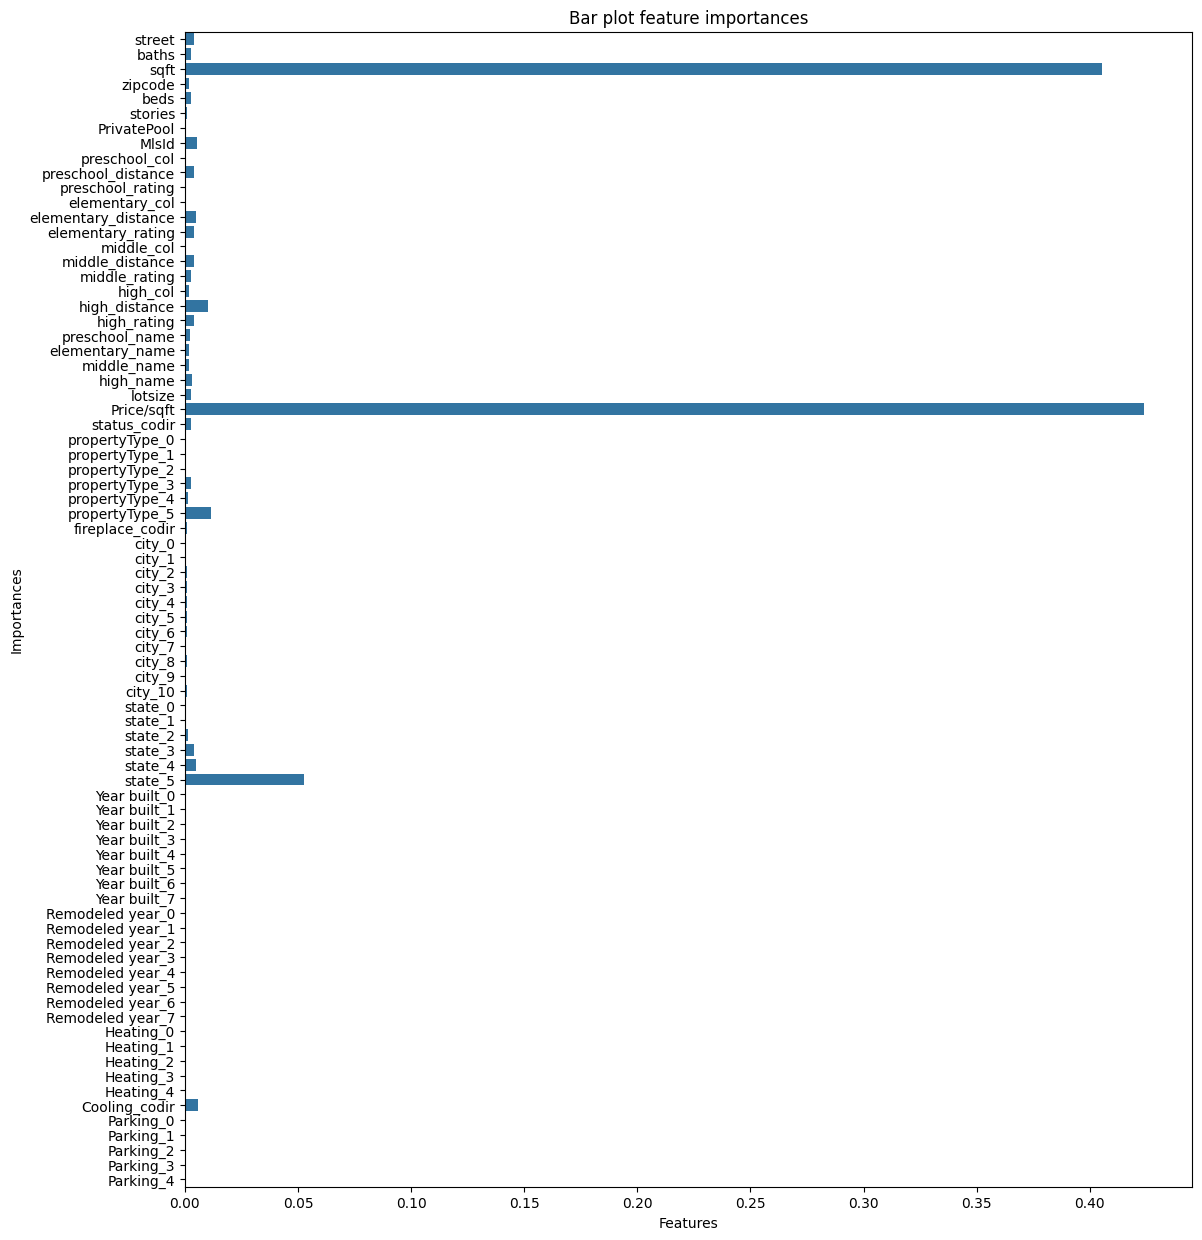

In [35]:
# Вывод графика с важностью признаков для target
fig, ax = plt.subplots(figsize=(13, 15)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = model.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature_importances, y=feature, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

После замены пропусков в данных sqft и Price/sqft приобрели ещё более выраженное воияние на target

### Обучение ML модели Catboost 

так как CatBoost не нуждается в предварительной кодировке данных типа object. Кодировку не провожу.

In [36]:
data_1 = data_remp_zero.copy()

In [37]:
%%time
features = data_1.columns.difference(['target'])  # All columns except 'stories'
target = 'target'

# Convert categorical features to strings
categorical_features = data_1[features].select_dtypes(include=['object']).columns
for feature in categorical_features:
    data_1[feature] = data_1[feature].astype(str)

X = data_1[features]
y = data_1[target]
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Создание списка номеров признаков с типом объект
categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

# Create CatBoost pools for training and testing
train_pool = Pool(data=X_train, label=y_train, cat_features = categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features = categorical_features_indices)

# Train the CatBoost model
model = CatBoostRegressor(iterations=100, depth=11, learning_rate=0.1, loss_function='RMSE', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
model.fit(train_pool)
metrica_catboost_with_out_zero = metrics.r2_score(y_test, model.predict(X_test))
print('Метрика R2: \033[3m\033[33m{}\033[0m'.format({metrica_catboost_with_out_zero}))

0:	learn: 227483.5307426	total: 83.4ms	remaining: 8.26s
99:	learn: 60424.4630709	total: 7.81s	remaining: 0us
Метрика R2: {0.9374989543003983}
CPU times: user 20.3 s, sys: 2.32 s, total: 22.6 s
Wall time: 24.6 s


### <center>Итоговая таблица по моделям обучения

In [70]:
itog = pd.DataFrame(data = [[metrica_rforest_with_zero, metrica_catboost_with_zero, metrica_rforest_with_out_zero,\
                              metrica_catboost_with_out_zero], ['9m 21s', '23.2s', '10m 48s', '24.6s']],\
                                columns=[('Без замены пропусков', 'RandomForestRegressor'), ('Без замены пропусков', 'CatBoostRegressor'),\
                        ('С заменой пропусков', 'RandomForestRegressor'), ('С заменой пропусков', 'CatBoostRegressor')],\
                          index=['Метрика', 'Время'])
itog.columns = pd.MultiIndex.from_tuples(itog.columns)

In [72]:
itog

Без замены пропусков                     С заменой пропусков  \
        RandomForestRegressor CatBoostRegressor RandomForestRegressor   
Метрика              0.913048          0.920369              0.939342   
Время                  9m 21s             23.2s               10m 48s   

                           
        CatBoostRegressor  
Метрика          0.937499  
Время               24.6s

### В итоге можно сделать выводы:

* Хорошая очистка данных сразу показывает хорошие результаты при обучении ML моделей.
    * разница между Random Forest и Cat Boost оказались очень близки. разника в 0.007 но время на выполнение обучения просто не сопоставимо
        * 9 минут 21 секунда Random Forest
        * 23.2 секунды CatBoost
* После замены пропусков в выбранных признаках метрика чуть подросла, но время на выполнение обучения опять не сравнимо:
    * 0.026 на Random Forest 10 минут 48 секунд
    * 0.017 на CatBoost 24.6 секунды

Для себя делаю вывод, CatBoost надо досконально изучать и использовать в дальнейшем. 

Ну а модель для предсказания цены на нежвижимость получилась качественная. Судя по метрике.
